In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "400X"
trainable_blocks = ["block4"]
irun = 2


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_400X-BREAKHIS-Dataset-60-10-30-VGGINet/2'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/400X/2'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 971 files belonging to 2 classes.


Found 161 files belonging to 2 classes.


Found 488 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1578 - accuracy: 0.5312

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/8 [======>.......................] - ETA: 2s - loss: 5.4653 - accuracy: 0.6133

3/8 [==========>...................] - ETA: 3s - loss: 5.0823 - accuracy: 0.6667

4/8 [==============>...............] - ETA: 4s - loss: 4.7522 - accuracy: 0.6914

5/8 [=================>............] - ETA: 3s - loss: 4.3752 - accuracy: 0.7156

6/8 [=====================>........] - ETA: 2s - loss: 4.2405 - accuracy: 0.7240

7/8 [=========================>....] - ETA: 1s - loss: 4.0780 - accuracy: 0.7254

8/8 [==============================] - ETA: 0s - loss: 4.0581 - accuracy: 0.7333

8/8 [==============================] - 20s 3s/step - loss: 4.0581 - accuracy: 0.7333 - val_loss: 40.4565 - val_accuracy: 0.4720


Epoch 2/100


1/8 [==>...........................] - ETA: 0s - loss: 4.7878 - accuracy: 0.7500

2/8 [======>.......................] - ETA: 10s - loss: 3.6153 - accuracy: 0.7812

3/8 [==========>...................] - ETA: 7s - loss: 3.3811 - accuracy: 0.7995 

4/8 [==============>...............] - ETA: 7s - loss: 3.0003 - accuracy: 0.8184

5/8 [=================>............] - ETA: 5s - loss: 2.8864 - accuracy: 0.8188

6/8 [=====================>........] - ETA: 3s - loss: 2.8703 - accuracy: 0.8203

7/8 [=========================>....] - ETA: 1s - loss: 2.7620 - accuracy: 0.8170

8/8 [==============================] - ETA: 0s - loss: 2.6857 - accuracy: 0.8208

8/8 [==============================] - 14s 2s/step - loss: 2.6857 - accuracy: 0.8208 - val_loss: 8.4162 - val_accuracy: 0.8199


Epoch 3/100


1/8 [==>...........................] - ETA: 0s - loss: 2.5374 - accuracy: 0.8438

2/8 [======>.......................] - ETA: 12s - loss: 2.0200 - accuracy: 0.8711

3/8 [==========>...................] - ETA: 8s - loss: 1.7896 - accuracy: 0.8802 

4/8 [==============>...............] - ETA: 7s - loss: 1.9869 - accuracy: 0.8691

5/8 [=================>............] - ETA: 5s - loss: 2.0808 - accuracy: 0.8641

6/8 [=====================>........] - ETA: 3s - loss: 2.0031 - accuracy: 0.8659

7/8 [=========================>....] - ETA: 1s - loss: 2.0743 - accuracy: 0.8538

8/8 [==============================] - ETA: 0s - loss: 2.0539 - accuracy: 0.8558

8/8 [==============================] - 14s 2s/step - loss: 2.0539 - accuracy: 0.8558 - val_loss: 2.7514 - val_accuracy: 0.9068


Epoch 4/100


1/8 [==>...........................] - ETA: 0s - loss: 2.5857 - accuracy: 0.8281

2/8 [======>.......................] - ETA: 10s - loss: 1.6526 - accuracy: 0.8633

3/8 [==========>...................] - ETA: 10s - loss: 1.4403 - accuracy: 0.8698

4/8 [==============>...............] - ETA: 6s - loss: 1.3031 - accuracy: 0.8711 

5/8 [=================>............] - ETA: 4s - loss: 1.4553 - accuracy: 0.8547

6/8 [=====================>........] - ETA: 2s - loss: 1.4149 - accuracy: 0.8555

7/8 [=========================>....] - ETA: 1s - loss: 1.3541 - accuracy: 0.8594

8/8 [==============================] - ETA: 0s - loss: 1.3461 - accuracy: 0.8599

8/8 [==============================] - 13s 2s/step - loss: 1.3461 - accuracy: 0.8599 - val_loss: 3.2597 - val_accuracy: 0.8199


Epoch 5/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2432 - accuracy: 0.8828

2/8 [======>.......................] - ETA: 11s - loss: 1.4689 - accuracy: 0.8867

3/8 [==========>...................] - ETA: 10s - loss: 1.2267 - accuracy: 0.8958

4/8 [==============>...............] - ETA: 7s - loss: 1.2336 - accuracy: 0.8887 

5/8 [=================>............] - ETA: 4s - loss: 1.2701 - accuracy: 0.8828

6/8 [=====================>........] - ETA: 2s - loss: 1.2414 - accuracy: 0.8828

7/8 [=========================>....] - ETA: 1s - loss: 1.2116 - accuracy: 0.8828

8/8 [==============================] - ETA: 0s - loss: 1.2225 - accuracy: 0.8857

8/8 [==============================] - 13s 2s/step - loss: 1.2225 - accuracy: 0.8857 - val_loss: 2.0071 - val_accuracy: 0.9255


Epoch 6/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7989 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 10s - loss: 1.0233 - accuracy: 0.8945

3/8 [==========>...................] - ETA: 8s - loss: 1.1061 - accuracy: 0.8880 

4/8 [==============>...............] - ETA: 7s - loss: 1.1921 - accuracy: 0.8828

5/8 [=================>............] - ETA: 5s - loss: 1.2282 - accuracy: 0.8828

6/8 [=====================>........] - ETA: 3s - loss: 1.2412 - accuracy: 0.8867

7/8 [=========================>....] - ETA: 1s - loss: 1.1736 - accuracy: 0.8929

8/8 [==============================] - ETA: 0s - loss: 1.1691 - accuracy: 0.8950

8/8 [==============================] - 14s 2s/step - loss: 1.1691 - accuracy: 0.8950 - val_loss: 1.4854 - val_accuracy: 0.9317


Epoch 7/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0737 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 12s - loss: 0.8258 - accuracy: 0.9141

3/8 [==========>...................] - ETA: 8s - loss: 0.8129 - accuracy: 0.9115 

4/8 [==============>...............] - ETA: 7s - loss: 0.9997 - accuracy: 0.8965

5/8 [=================>............] - ETA: 4s - loss: 0.8650 - accuracy: 0.9094

6/8 [=====================>........] - ETA: 2s - loss: 0.9766 - accuracy: 0.9076

7/8 [=========================>....] - ETA: 1s - loss: 0.9915 - accuracy: 0.9051

8/8 [==============================] - ETA: 0s - loss: 1.0380 - accuracy: 0.8970

8/8 [==============================] - 13s 2s/step - loss: 1.0380 - accuracy: 0.8970 - val_loss: 1.3675 - val_accuracy: 0.9255


Epoch 8/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0989 - accuracy: 0.8984

2/8 [======>.......................] - ETA: 11s - loss: 1.2855 - accuracy: 0.8867

3/8 [==========>...................] - ETA: 8s - loss: 1.1043 - accuracy: 0.8984 

4/8 [==============>...............] - ETA: 7s - loss: 1.1318 - accuracy: 0.8965

5/8 [=================>............] - ETA: 4s - loss: 1.0201 - accuracy: 0.9016

6/8 [=====================>........] - ETA: 2s - loss: 0.9704 - accuracy: 0.9023

7/8 [=========================>....] - ETA: 1s - loss: 0.9654 - accuracy: 0.8973

8/8 [==============================] - ETA: 0s - loss: 1.0159 - accuracy: 0.8929

8/8 [==============================] - 13s 2s/step - loss: 1.0159 - accuracy: 0.8929 - val_loss: 1.3379 - val_accuracy: 0.9255


Epoch 9/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2617 - accuracy: 0.8594

2/8 [======>.......................] - ETA: 11s - loss: 1.3875 - accuracy: 0.8672

3/8 [==========>...................] - ETA: 11s - loss: 1.3361 - accuracy: 0.8776

4/8 [==============>...............] - ETA: 7s - loss: 1.1708 - accuracy: 0.8945 

5/8 [=================>............] - ETA: 5s - loss: 1.1718 - accuracy: 0.8953

6/8 [=====================>........] - ETA: 3s - loss: 1.0965 - accuracy: 0.8984

7/8 [=========================>....] - ETA: 1s - loss: 1.0369 - accuracy: 0.9029

8/8 [==============================] - ETA: 0s - loss: 1.0814 - accuracy: 0.8991

8/8 [==============================] - 14s 2s/step - loss: 1.0814 - accuracy: 0.8991 - val_loss: 1.5493 - val_accuracy: 0.9130


Epoch 10/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1969 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 10s - loss: 1.0985 - accuracy: 0.9180

3/8 [==========>...................] - ETA: 10s - loss: 1.2182 - accuracy: 0.9036

4/8 [==============>...............] - ETA: 7s - loss: 1.0754 - accuracy: 0.9062 

5/8 [=================>............] - ETA: 4s - loss: 1.0981 - accuracy: 0.9016

6/8 [=====================>........] - ETA: 2s - loss: 0.9965 - accuracy: 0.9089

7/8 [=========================>....] - ETA: 1s - loss: 0.9470 - accuracy: 0.9118

8/8 [==============================] - ETA: 0s - loss: 0.9652 - accuracy: 0.9125

8/8 [==============================] - 13s 2s/step - loss: 0.9652 - accuracy: 0.9125 - val_loss: 1.8290 - val_accuracy: 0.8758


Epoch 11/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7235 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.9222 - accuracy: 0.8906

3/8 [==========>...................] - ETA: 8s - loss: 0.9700 - accuracy: 0.8958 

4/8 [==============>...............] - ETA: 7s - loss: 1.1006 - accuracy: 0.8945

5/8 [=================>............] - ETA: 4s - loss: 1.1263 - accuracy: 0.8969

6/8 [=====================>........] - ETA: 2s - loss: 1.1048 - accuracy: 0.8984

7/8 [=========================>....] - ETA: 1s - loss: 1.0672 - accuracy: 0.8973

8/8 [==============================] - ETA: 0s - loss: 1.1131 - accuracy: 0.8939

8/8 [==============================] - 13s 2s/step - loss: 1.1131 - accuracy: 0.8939 - val_loss: 1.4228 - val_accuracy: 0.9130


Epoch 12/100


1/8 [==>...........................] - ETA: 0s - loss: 1.6012 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 11s - loss: 1.1970 - accuracy: 0.9062

3/8 [==========>...................] - ETA: 8s - loss: 1.1606 - accuracy: 0.9036 

4/8 [==============>...............] - ETA: 7s - loss: 1.1522 - accuracy: 0.9043

5/8 [=================>............] - ETA: 4s - loss: 1.3210 - accuracy: 0.8906

6/8 [=====================>........] - ETA: 2s - loss: 1.2613 - accuracy: 0.8945

7/8 [=========================>....] - ETA: 1s - loss: 1.1666 - accuracy: 0.8984

8/8 [==============================] - ETA: 0s - loss: 1.1414 - accuracy: 0.9011

8/8 [==============================] - 13s 2s/step - loss: 1.1414 - accuracy: 0.9011 - val_loss: 1.7076 - val_accuracy: 0.9255


Epoch 13/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8273 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 11s - loss: 0.7167 - accuracy: 0.9219

3/8 [==========>...................] - ETA: 8s - loss: 0.7984 - accuracy: 0.9062 

4/8 [==============>...............] - ETA: 7s - loss: 0.8207 - accuracy: 0.8926

5/8 [=================>............] - ETA: 4s - loss: 0.8198 - accuracy: 0.8984

6/8 [=====================>........] - ETA: 3s - loss: 0.8530 - accuracy: 0.8984

7/8 [=========================>....] - ETA: 1s - loss: 0.8575 - accuracy: 0.9007

8/8 [==============================] - ETA: 0s - loss: 0.8911 - accuracy: 0.9022

8/8 [==============================] - 14s 2s/step - loss: 0.8911 - accuracy: 0.9022 - val_loss: 1.0732 - val_accuracy: 0.9379


Epoch 14/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4367 - accuracy: 0.8750

2/8 [======>.......................] - ETA: 10s - loss: 0.9111 - accuracy: 0.9062

3/8 [==========>...................] - ETA: 8s - loss: 0.9667 - accuracy: 0.9036 

4/8 [==============>...............] - ETA: 6s - loss: 1.1756 - accuracy: 0.8984

5/8 [=================>............] - ETA: 4s - loss: 1.2435 - accuracy: 0.8953

6/8 [=====================>........] - ETA: 2s - loss: 1.1942 - accuracy: 0.8932

7/8 [=========================>....] - ETA: 1s - loss: 1.1846 - accuracy: 0.8951

8/8 [==============================] - ETA: 0s - loss: 1.1633 - accuracy: 0.8980

8/8 [==============================] - 13s 2s/step - loss: 1.1633 - accuracy: 0.8980 - val_loss: 2.5644 - val_accuracy: 0.8571


Epoch 15/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8209 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 1.2158 - accuracy: 0.8945

3/8 [==========>...................] - ETA: 8s - loss: 1.0221 - accuracy: 0.9036 

4/8 [==============>...............] - ETA: 6s - loss: 1.0213 - accuracy: 0.9102

5/8 [=================>............] - ETA: 4s - loss: 1.0270 - accuracy: 0.9125

6/8 [=====================>........] - ETA: 2s - loss: 0.9480 - accuracy: 0.9141

7/8 [=========================>....] - ETA: 1s - loss: 0.9807 - accuracy: 0.9152

8/8 [==============================] - ETA: 0s - loss: 0.9756 - accuracy: 0.9135

8/8 [==============================] - 13s 2s/step - loss: 0.9756 - accuracy: 0.9135 - val_loss: 1.4677 - val_accuracy: 0.9193


Epoch 16/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9696 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 0.8982 - accuracy: 0.9258

3/8 [==========>...................] - ETA: 7s - loss: 0.8611 - accuracy: 0.9323 

4/8 [==============>...............] - ETA: 7s - loss: 0.8350 - accuracy: 0.9355

5/8 [=================>............] - ETA: 5s - loss: 0.8735 - accuracy: 0.9203

6/8 [=====================>........] - ETA: 3s - loss: 0.8278 - accuracy: 0.9232

7/8 [=========================>....] - ETA: 1s - loss: 0.8639 - accuracy: 0.9196

8/8 [==============================] - ETA: 0s - loss: 0.9123 - accuracy: 0.9186

8/8 [==============================] - 14s 2s/step - loss: 0.9123 - accuracy: 0.9186 - val_loss: 1.4980 - val_accuracy: 0.9193


Epoch 17/100


1/8 [==>...........................] - ETA: 0s - loss: 1.3230 - accuracy: 0.8594

2/8 [======>.......................] - ETA: 13s - loss: 1.3146 - accuracy: 0.8828

3/8 [==========>...................] - ETA: 12s - loss: 1.1134 - accuracy: 0.8932

4/8 [==============>...............] - ETA: 8s - loss: 1.0146 - accuracy: 0.8984 

5/8 [=================>............] - ETA: 5s - loss: 1.0462 - accuracy: 0.9016

6/8 [=====================>........] - ETA: 3s - loss: 0.9544 - accuracy: 0.9023

7/8 [=========================>....] - ETA: 1s - loss: 0.9293 - accuracy: 0.9040

8/8 [==============================] - ETA: 0s - loss: 0.8987 - accuracy: 0.9042

8/8 [==============================] - 15s 2s/step - loss: 0.8987 - accuracy: 0.9042 - val_loss: 2.7577 - val_accuracy: 0.8758


Epoch 18/100


1/8 [==>...........................] - ETA: 0s - loss: 1.3453 - accuracy: 0.8750

2/8 [======>.......................] - ETA: 11s - loss: 1.2278 - accuracy: 0.8984

3/8 [==========>...................] - ETA: 7s - loss: 1.0358 - accuracy: 0.9167 

4/8 [==============>...............] - ETA: 7s - loss: 1.0662 - accuracy: 0.9199

5/8 [=================>............] - ETA: 5s - loss: 1.1384 - accuracy: 0.9203

6/8 [=====================>........] - ETA: 3s - loss: 1.0826 - accuracy: 0.9219

7/8 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.9252

8/8 [==============================] - ETA: 0s - loss: 0.9898 - accuracy: 0.9238

8/8 [==============================] - 14s 2s/step - loss: 0.9898 - accuracy: 0.9238 - val_loss: 1.1534 - val_accuracy: 0.9193


Epoch 19/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2808 - accuracy: 0.8828

2/8 [======>.......................] - ETA: 10s - loss: 1.1726 - accuracy: 0.8867

3/8 [==========>...................] - ETA: 7s - loss: 1.0931 - accuracy: 0.9010 

4/8 [==============>...............] - ETA: 6s - loss: 1.1383 - accuracy: 0.8906

5/8 [=================>............] - ETA: 4s - loss: 0.9734 - accuracy: 0.9016

6/8 [=====================>........] - ETA: 2s - loss: 1.0894 - accuracy: 0.8971

7/8 [=========================>....] - ETA: 1s - loss: 1.1063 - accuracy: 0.9018

8/8 [==============================] - ETA: 0s - loss: 1.1034 - accuracy: 0.9011

8/8 [==============================] - 13s 2s/step - loss: 1.1034 - accuracy: 0.9011 - val_loss: 0.9703 - val_accuracy: 0.9193


Epoch 20/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8714 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 0.7540 - accuracy: 0.9297

3/8 [==========>...................] - ETA: 8s - loss: 0.9036 - accuracy: 0.9245 

4/8 [==============>...............] - ETA: 7s - loss: 0.8804 - accuracy: 0.9297

5/8 [=================>............] - ETA: 5s - loss: 0.8983 - accuracy: 0.9219

6/8 [=====================>........] - ETA: 3s - loss: 0.9131 - accuracy: 0.9245

7/8 [=========================>....] - ETA: 1s - loss: 0.8340 - accuracy: 0.9275

8/8 [==============================] - ETA: 0s - loss: 0.8598 - accuracy: 0.9248

8/8 [==============================] - 14s 2s/step - loss: 0.8598 - accuracy: 0.9248 - val_loss: 0.8569 - val_accuracy: 0.9317


Epoch 21/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7033 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.6220 - accuracy: 0.9219

3/8 [==========>...................] - ETA: 8s - loss: 0.4786 - accuracy: 0.9349 

4/8 [==============>...............] - ETA: 7s - loss: 0.7539 - accuracy: 0.9219

5/8 [=================>............] - ETA: 5s - loss: 0.7074 - accuracy: 0.9234

6/8 [=====================>........] - ETA: 3s - loss: 0.7657 - accuracy: 0.9193

7/8 [=========================>....] - ETA: 1s - loss: 0.7251 - accuracy: 0.9230

8/8 [==============================] - ETA: 0s - loss: 0.7186 - accuracy: 0.9238

8/8 [==============================] - 14s 2s/step - loss: 0.7186 - accuracy: 0.9238 - val_loss: 1.4473 - val_accuracy: 0.9193


Epoch 22/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5741 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 11s - loss: 0.8048 - accuracy: 0.9062

3/8 [==========>...................] - ETA: 8s - loss: 0.7552 - accuracy: 0.9219 

4/8 [==============>...............] - ETA: 7s - loss: 0.7626 - accuracy: 0.9238

5/8 [=================>............] - ETA: 5s - loss: 0.6588 - accuracy: 0.9297

6/8 [=====================>........] - ETA: 3s - loss: 0.8195 - accuracy: 0.9180

7/8 [=========================>....] - ETA: 1s - loss: 0.8419 - accuracy: 0.9174

8/8 [==============================] - ETA: 0s - loss: 0.8094 - accuracy: 0.9166

8/8 [==============================] - 14s 2s/step - loss: 0.8094 - accuracy: 0.9166 - val_loss: 1.6730 - val_accuracy: 0.9193


Epoch 23/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1331 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 12s - loss: 1.0966 - accuracy: 0.9180

3/8 [==========>...................] - ETA: 8s - loss: 0.9822 - accuracy: 0.9245 

4/8 [==============>...............] - ETA: 7s - loss: 0.9218 - accuracy: 0.9277

5/8 [=================>............] - ETA: 4s - loss: 0.9069 - accuracy: 0.9234

6/8 [=====================>........] - ETA: 2s - loss: 0.9227 - accuracy: 0.9245

7/8 [=========================>....] - ETA: 1s - loss: 0.8916 - accuracy: 0.9241

8/8 [==============================] - ETA: 0s - loss: 0.8436 - accuracy: 0.9269

8/8 [==============================] - 13s 2s/step - loss: 0.8436 - accuracy: 0.9269 - val_loss: 1.5193 - val_accuracy: 0.9379


Epoch 24/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6056 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 13s - loss: 0.8976 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 12s - loss: 1.1051 - accuracy: 0.9401

4/8 [==============>...............] - ETA: 8s - loss: 1.0731 - accuracy: 0.9375 

5/8 [=================>............] - ETA: 5s - loss: 0.9354 - accuracy: 0.9438

6/8 [=====================>........] - ETA: 3s - loss: 0.9059 - accuracy: 0.9414

7/8 [=========================>....] - ETA: 1s - loss: 0.9410 - accuracy: 0.9420

8/8 [==============================] - ETA: 0s - loss: 0.8870 - accuracy: 0.9423

8/8 [==============================] - 15s 2s/step - loss: 0.8870 - accuracy: 0.9423 - val_loss: 2.0468 - val_accuracy: 0.8820


Epoch 25/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9330 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 11s - loss: 1.2983 - accuracy: 0.8945

3/8 [==========>...................] - ETA: 7s - loss: 1.3932 - accuracy: 0.8932 

4/8 [==============>...............] - ETA: 6s - loss: 1.2507 - accuracy: 0.9102

5/8 [=================>............] - ETA: 4s - loss: 1.1054 - accuracy: 0.9203

6/8 [=====================>........] - ETA: 2s - loss: 1.1633 - accuracy: 0.9193

7/8 [=========================>....] - ETA: 1s - loss: 1.2307 - accuracy: 0.9141

8/8 [==============================] - ETA: 0s - loss: 1.1602 - accuracy: 0.9176

8/8 [==============================] - 13s 2s/step - loss: 1.1602 - accuracy: 0.9176 - val_loss: 2.1174 - val_accuracy: 0.9193


Epoch 26/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1904 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.1779 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.5495 - accuracy: 0.9531 

4/8 [==============>...............] - ETA: 7s - loss: 0.8396 - accuracy: 0.9434

5/8 [=================>............] - ETA: 4s - loss: 0.8413 - accuracy: 0.9359

6/8 [=====================>........] - ETA: 2s - loss: 0.8018 - accuracy: 0.9401

7/8 [=========================>....] - ETA: 1s - loss: 0.8757 - accuracy: 0.9375

8/8 [==============================] - ETA: 0s - loss: 0.8914 - accuracy: 0.9341

8/8 [==============================] - 13s 2s/step - loss: 0.8914 - accuracy: 0.9341 - val_loss: 2.0338 - val_accuracy: 0.9068


Epoch 27/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8619 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 0.7313 - accuracy: 0.9297

3/8 [==========>...................] - ETA: 7s - loss: 0.6444 - accuracy: 0.9401 

4/8 [==============>...............] - ETA: 6s - loss: 0.6993 - accuracy: 0.9414

5/8 [=================>............] - ETA: 4s - loss: 0.7894 - accuracy: 0.9344

6/8 [=====================>........] - ETA: 2s - loss: 0.7176 - accuracy: 0.9375

7/8 [=========================>....] - ETA: 1s - loss: 0.6821 - accuracy: 0.9397

8/8 [==============================] - ETA: 0s - loss: 0.7210 - accuracy: 0.9341

8/8 [==============================] - 13s 2s/step - loss: 0.7210 - accuracy: 0.9341 - val_loss: 2.9297 - val_accuracy: 0.8323


Epoch 28/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9385 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 11s - loss: 0.7271 - accuracy: 0.9258

3/8 [==========>...................] - ETA: 7s - loss: 0.6978 - accuracy: 0.9349 

4/8 [==============>...............] - ETA: 6s - loss: 0.7068 - accuracy: 0.9316

5/8 [=================>............] - ETA: 4s - loss: 0.6532 - accuracy: 0.9375

6/8 [=====================>........] - ETA: 2s - loss: 0.6348 - accuracy: 0.9401

7/8 [=========================>....] - ETA: 1s - loss: 0.5769 - accuracy: 0.9420

8/8 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.9444

8/8 [==============================] - 13s 2s/step - loss: 0.5628 - accuracy: 0.9444 - val_loss: 1.3639 - val_accuracy: 0.9379


Epoch 29/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6322 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.7912 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 8s - loss: 0.6868 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 7s - loss: 0.7336 - accuracy: 0.9395

5/8 [=================>............] - ETA: 4s - loss: 0.9066 - accuracy: 0.9344

6/8 [=====================>........] - ETA: 3s - loss: 0.9961 - accuracy: 0.9297

7/8 [=========================>....] - ETA: 1s - loss: 0.8672 - accuracy: 0.9364

8/8 [==============================] - ETA: 0s - loss: 0.8147 - accuracy: 0.9372

8/8 [==============================] - 13s 2s/step - loss: 0.8147 - accuracy: 0.9372 - val_loss: 1.3253 - val_accuracy: 0.9441


Epoch 30/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1368 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 10s - loss: 1.0435 - accuracy: 0.9258

3/8 [==========>...................] - ETA: 7s - loss: 0.9261 - accuracy: 0.9349 

4/8 [==============>...............] - ETA: 6s - loss: 0.8410 - accuracy: 0.9395

5/8 [=================>............] - ETA: 4s - loss: 0.7930 - accuracy: 0.9422

6/8 [=====================>........] - ETA: 2s - loss: 0.8505 - accuracy: 0.9375

7/8 [=========================>....] - ETA: 1s - loss: 0.7895 - accuracy: 0.9420

8/8 [==============================] - ETA: 0s - loss: 0.7901 - accuracy: 0.9382

8/8 [==============================] - 13s 2s/step - loss: 0.7901 - accuracy: 0.9382 - val_loss: 1.2879 - val_accuracy: 0.9379


Epoch 31/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2424 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 10s - loss: 0.9061 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 10s - loss: 0.6453 - accuracy: 0.9479

4/8 [==============>...............] - ETA: 9s - loss: 0.8222 - accuracy: 0.9434 

5/8 [=================>............] - ETA: 6s - loss: 0.7415 - accuracy: 0.9469

6/8 [=====================>........] - ETA: 3s - loss: 0.7502 - accuracy: 0.9440

7/8 [=========================>....] - ETA: 1s - loss: 0.7040 - accuracy: 0.9453

8/8 [==============================] - ETA: 0s - loss: 0.7022 - accuracy: 0.9464

8/8 [==============================] - 16s 2s/step - loss: 0.7022 - accuracy: 0.9464 - val_loss: 1.5471 - val_accuracy: 0.9255


Epoch 32/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7783 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 10s - loss: 0.5849 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 7s - loss: 0.5936 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 7s - loss: 0.7805 - accuracy: 0.9297

5/8 [=================>............] - ETA: 5s - loss: 0.8108 - accuracy: 0.9281

6/8 [=====================>........] - ETA: 3s - loss: 0.8156 - accuracy: 0.9323

7/8 [=========================>....] - ETA: 1s - loss: 0.8361 - accuracy: 0.9330

8/8 [==============================] - ETA: 0s - loss: 0.8004 - accuracy: 0.9341

8/8 [==============================] - 14s 2s/step - loss: 0.8004 - accuracy: 0.9341 - val_loss: 1.4634 - val_accuracy: 0.9255


Epoch 33/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0592 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 1.0523 - accuracy: 0.9336

3/8 [==========>...................] - ETA: 7s - loss: 0.8152 - accuracy: 0.9401 

4/8 [==============>...............] - ETA: 6s - loss: 0.6498 - accuracy: 0.9512

5/8 [=================>............] - ETA: 4s - loss: 0.5796 - accuracy: 0.9547

6/8 [=====================>........] - ETA: 2s - loss: 0.6553 - accuracy: 0.9557

7/8 [=========================>....] - ETA: 1s - loss: 0.6370 - accuracy: 0.9542

8/8 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.9526

8/8 [==============================] - 13s 2s/step - loss: 0.6550 - accuracy: 0.9526 - val_loss: 1.1470 - val_accuracy: 0.9255


Epoch 34/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7101 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 10s - loss: 0.9088 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 7s - loss: 0.8396 - accuracy: 0.9323 

4/8 [==============>...............] - ETA: 6s - loss: 0.7068 - accuracy: 0.9375

5/8 [=================>............] - ETA: 4s - loss: 0.6589 - accuracy: 0.9438

6/8 [=====================>........] - ETA: 2s - loss: 0.6470 - accuracy: 0.9414

7/8 [=========================>....] - ETA: 1s - loss: 0.7844 - accuracy: 0.9353

8/8 [==============================] - ETA: 0s - loss: 0.7760 - accuracy: 0.9361

8/8 [==============================] - 13s 2s/step - loss: 0.7760 - accuracy: 0.9361 - val_loss: 1.6620 - val_accuracy: 0.9317


Epoch 35/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8126 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 13s - loss: 0.7835 - accuracy: 0.9258

3/8 [==========>...................] - ETA: 9s - loss: 0.7062 - accuracy: 0.9245 

4/8 [==============>...............] - ETA: 7s - loss: 0.6971 - accuracy: 0.9277

5/8 [=================>............] - ETA: 4s - loss: 0.5769 - accuracy: 0.9375

6/8 [=====================>........] - ETA: 3s - loss: 0.5540 - accuracy: 0.9401

7/8 [=========================>....] - ETA: 1s - loss: 0.6401 - accuracy: 0.9397

8/8 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.9413

8/8 [==============================] - 14s 2s/step - loss: 0.6164 - accuracy: 0.9413 - val_loss: 1.7077 - val_accuracy: 0.9503


Epoch 36/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5131 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 1.1012 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 8s - loss: 1.1599 - accuracy: 0.9219 

4/8 [==============>...............] - ETA: 7s - loss: 0.9079 - accuracy: 0.9395

5/8 [=================>............] - ETA: 5s - loss: 0.7862 - accuracy: 0.9438

6/8 [=====================>........] - ETA: 3s - loss: 0.8463 - accuracy: 0.9414

7/8 [=========================>....] - ETA: 1s - loss: 0.8243 - accuracy: 0.9453

8/8 [==============================] - ETA: 0s - loss: 0.8136 - accuracy: 0.9454

8/8 [==============================] - 14s 2s/step - loss: 0.8136 - accuracy: 0.9454 - val_loss: 2.5746 - val_accuracy: 0.9317


Epoch 37/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5085 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.9944 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 7s - loss: 0.8663 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 7s - loss: 0.7636 - accuracy: 0.9473

5/8 [=================>............] - ETA: 5s - loss: 0.7322 - accuracy: 0.9438

6/8 [=====================>........] - ETA: 3s - loss: 0.7630 - accuracy: 0.9375

7/8 [=========================>....] - ETA: 1s - loss: 0.7609 - accuracy: 0.9397

8/8 [==============================] - ETA: 0s - loss: 0.7551 - accuracy: 0.9403

8/8 [==============================] - 14s 2s/step - loss: 0.7551 - accuracy: 0.9403 - val_loss: 1.6903 - val_accuracy: 0.9317


Epoch 38/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5900 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 2s - loss: 0.3919 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 3s - loss: 0.4100 - accuracy: 0.9531

4/8 [==============>...............] - ETA: 4s - loss: 0.4749 - accuracy: 0.9492

5/8 [=================>............] - ETA: 3s - loss: 0.6088 - accuracy: 0.9469

6/8 [=====================>........] - ETA: 2s - loss: 0.6170 - accuracy: 0.9440

7/8 [=========================>....] - ETA: 1s - loss: 0.6583 - accuracy: 0.9453

8/8 [==============================] - ETA: 0s - loss: 0.6292 - accuracy: 0.9475

8/8 [==============================] - 11s 1s/step - loss: 0.6292 - accuracy: 0.9475 - val_loss: 2.8165 - val_accuracy: 0.8509


Epoch 39/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0926 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 10s - loss: 0.3215 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 7s - loss: 0.3935 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 6s - loss: 0.4873 - accuracy: 0.9531

5/8 [=================>............] - ETA: 4s - loss: 0.5028 - accuracy: 0.9500

6/8 [=====================>........] - ETA: 2s - loss: 0.5560 - accuracy: 0.9505

7/8 [=========================>....] - ETA: 1s - loss: 0.7854 - accuracy: 0.9442

8/8 [==============================] - ETA: 0s - loss: 0.7864 - accuracy: 0.9423

8/8 [==============================] - 13s 2s/step - loss: 0.7864 - accuracy: 0.9423 - val_loss: 2.3036 - val_accuracy: 0.9006


Epoch 40/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8068 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.9573 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 7s - loss: 0.6742 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.6119 - accuracy: 0.9609

5/8 [=================>............] - ETA: 5s - loss: 0.5709 - accuracy: 0.9594

6/8 [=====================>........] - ETA: 3s - loss: 0.5221 - accuracy: 0.9609

7/8 [=========================>....] - ETA: 1s - loss: 0.4753 - accuracy: 0.9621

8/8 [==============================] - ETA: 0s - loss: 0.4386 - accuracy: 0.9650

8/8 [==============================] - 14s 2s/step - loss: 0.4386 - accuracy: 0.9650 - val_loss: 1.1727 - val_accuracy: 0.9379


Epoch 41/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1765 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.3122 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 7s - loss: 0.4696 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.4268 - accuracy: 0.9609

5/8 [=================>............] - ETA: 5s - loss: 0.5721 - accuracy: 0.9563

6/8 [=====================>........] - ETA: 3s - loss: 0.5745 - accuracy: 0.9557

7/8 [=========================>....] - ETA: 1s - loss: 0.4985 - accuracy: 0.9598

8/8 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.9609

8/8 [==============================] - 14s 2s/step - loss: 0.5103 - accuracy: 0.9609 - val_loss: 1.6304 - val_accuracy: 0.9317


Epoch 42/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2578 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 10s - loss: 0.9330 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 7s - loss: 0.8323 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 6s - loss: 0.7183 - accuracy: 0.9492

5/8 [=================>............] - ETA: 4s - loss: 0.8037 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 2s - loss: 0.7310 - accuracy: 0.9505

7/8 [=========================>....] - ETA: 1s - loss: 0.6657 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.9537

8/8 [==============================] - 13s 2s/step - loss: 0.6223 - accuracy: 0.9537 - val_loss: 1.9514 - val_accuracy: 0.9255


Epoch 43/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4614 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 3s - loss: 0.5280 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 5s - loss: 0.4605 - accuracy: 0.9557

4/8 [==============>...............] - ETA: 4s - loss: 0.5922 - accuracy: 0.9492

5/8 [=================>............] - ETA: 3s - loss: 0.5935 - accuracy: 0.9516

6/8 [=====================>........] - ETA: 2s - loss: 0.5650 - accuracy: 0.9531

7/8 [=========================>....] - ETA: 1s - loss: 0.5626 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.5495 - accuracy: 0.9547

8/8 [==============================] - 11s 1s/step - loss: 0.5495 - accuracy: 0.9547 - val_loss: 1.4904 - val_accuracy: 0.9379


Epoch 44/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4438 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.5305 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 7s - loss: 0.5334 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.4216 - accuracy: 0.9668

5/8 [=================>............] - ETA: 4s - loss: 0.3674 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 2s - loss: 0.3416 - accuracy: 0.9688

7/8 [=========================>....] - ETA: 1s - loss: 0.3583 - accuracy: 0.9665

8/8 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.9650

8/8 [==============================] - 13s 2s/step - loss: 0.3770 - accuracy: 0.9650 - val_loss: 1.4017 - val_accuracy: 0.9255


Epoch 45/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2846 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.4427 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 11s - loss: 0.4527 - accuracy: 0.9661

4/8 [==============>...............] - ETA: 7s - loss: 0.4475 - accuracy: 0.9570 

5/8 [=================>............] - ETA: 5s - loss: 0.4665 - accuracy: 0.9563

6/8 [=====================>........] - ETA: 3s - loss: 0.4449 - accuracy: 0.9570

7/8 [=========================>....] - ETA: 1s - loss: 0.5339 - accuracy: 0.9565

8/8 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.9588

8/8 [==============================] - 14s 2s/step - loss: 0.5098 - accuracy: 0.9588 - val_loss: 1.7882 - val_accuracy: 0.9193


Epoch 46/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0037 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.6114 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.4831 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 6s - loss: 0.5353 - accuracy: 0.9570

5/8 [=================>............] - ETA: 4s - loss: 0.4874 - accuracy: 0.9594

6/8 [=====================>........] - ETA: 2s - loss: 0.4873 - accuracy: 0.9609

7/8 [=========================>....] - ETA: 1s - loss: 0.4610 - accuracy: 0.9643

8/8 [==============================] - ETA: 0s - loss: 0.5126 - accuracy: 0.9598

8/8 [==============================] - 13s 2s/step - loss: 0.5126 - accuracy: 0.9598 - val_loss: 1.9025 - val_accuracy: 0.9130


Epoch 47/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0701 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.3520 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 10s - loss: 0.2518 - accuracy: 0.9609

4/8 [==============>...............] - ETA: 7s - loss: 0.3104 - accuracy: 0.9570 

5/8 [=================>............] - ETA: 4s - loss: 0.4638 - accuracy: 0.9547

6/8 [=====================>........] - ETA: 2s - loss: 0.4993 - accuracy: 0.9518

7/8 [=========================>....] - ETA: 1s - loss: 0.6433 - accuracy: 0.9487

8/8 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.9475

8/8 [==============================] - 13s 2s/step - loss: 0.6739 - accuracy: 0.9475 - val_loss: 1.8168 - val_accuracy: 0.9130


Epoch 48/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4911 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.4842 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 10s - loss: 0.6652 - accuracy: 0.9557

4/8 [==============>...............] - ETA: 7s - loss: 0.5746 - accuracy: 0.9570 

5/8 [=================>............] - ETA: 4s - loss: 0.5333 - accuracy: 0.9594

6/8 [=====================>........] - ETA: 3s - loss: 0.4934 - accuracy: 0.9622

7/8 [=========================>....] - ETA: 1s - loss: 0.5489 - accuracy: 0.9587

8/8 [==============================] - ETA: 0s - loss: 0.5290 - accuracy: 0.9578

8/8 [==============================] - 14s 2s/step - loss: 0.5290 - accuracy: 0.9578 - val_loss: 1.2796 - val_accuracy: 0.9503


Epoch 49/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4239 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 10s - loss: 0.4425 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.3948 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.3264 - accuracy: 0.9707

5/8 [=================>............] - ETA: 4s - loss: 0.2877 - accuracy: 0.9703

6/8 [=====================>........] - ETA: 3s - loss: 0.3145 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.3303 - accuracy: 0.9676

8/8 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.9691

8/8 [==============================] - 14s 2s/step - loss: 0.3095 - accuracy: 0.9691 - val_loss: 1.7820 - val_accuracy: 0.9317


Epoch 50/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5360 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 10s - loss: 0.5444 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 7s - loss: 0.5420 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.4130 - accuracy: 0.9668

5/8 [=================>............] - ETA: 5s - loss: 0.4973 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 3s - loss: 0.5191 - accuracy: 0.9661

7/8 [=========================>....] - ETA: 1s - loss: 0.4821 - accuracy: 0.9676

8/8 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.9670

8/8 [==============================] - 14s 2s/step - loss: 0.4778 - accuracy: 0.9670 - val_loss: 1.9080 - val_accuracy: 0.9317


Epoch 51/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4068 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.4680 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.4405 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 6s - loss: 0.3306 - accuracy: 0.9707

5/8 [=================>............] - ETA: 4s - loss: 0.2972 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 2s - loss: 0.2858 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.2790 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.9691

8/8 [==============================] - 13s 2s/step - loss: 0.2728 - accuracy: 0.9691 - val_loss: 2.5718 - val_accuracy: 0.8944


Epoch 52/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4616 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 2s - loss: 0.4262 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 3s - loss: 0.5067 - accuracy: 0.9609

4/8 [==============>...............] - ETA: 4s - loss: 0.4606 - accuracy: 0.9590

5/8 [=================>............] - ETA: 3s - loss: 0.4310 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 1s - loss: 0.4047 - accuracy: 0.9622

7/8 [=========================>....] - ETA: 0s - loss: 0.6566 - accuracy: 0.9542

8/8 [==============================] - ETA: 0s - loss: 0.6488 - accuracy: 0.9557

8/8 [==============================] - 10s 1s/step - loss: 0.6488 - accuracy: 0.9557 - val_loss: 2.8706 - val_accuracy: 0.9068


Epoch 53/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9071 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 3s - loss: 0.6201 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 7s - loss: 0.5946 - accuracy: 0.9453

4/8 [==============>...............] - ETA: 7s - loss: 0.5604 - accuracy: 0.9492

5/8 [=================>............] - ETA: 4s - loss: 0.6115 - accuracy: 0.9484

6/8 [=====================>........] - ETA: 3s - loss: 0.6325 - accuracy: 0.9479

7/8 [=========================>....] - ETA: 1s - loss: 0.5538 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.5376 - accuracy: 0.9526

8/8 [==============================] - 14s 2s/step - loss: 0.5376 - accuracy: 0.9526 - val_loss: 2.3489 - val_accuracy: 0.9130


Epoch 54/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4803 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.6617 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 7s - loss: 0.6283 - accuracy: 0.9557 

4/8 [==============>...............] - ETA: 7s - loss: 0.6244 - accuracy: 0.9512

5/8 [=================>............] - ETA: 4s - loss: 0.5447 - accuracy: 0.9578

6/8 [=====================>........] - ETA: 2s - loss: 0.4713 - accuracy: 0.9622

7/8 [=========================>....] - ETA: 1s - loss: 0.5927 - accuracy: 0.9565

8/8 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.9567

8/8 [==============================] - 13s 2s/step - loss: 0.5731 - accuracy: 0.9567 - val_loss: 1.3429 - val_accuracy: 0.9441


Epoch 55/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4895 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.7012 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 7s - loss: 0.7506 - accuracy: 0.9479 

4/8 [==============>...............] - ETA: 7s - loss: 0.6628 - accuracy: 0.9492

5/8 [=================>............] - ETA: 4s - loss: 0.6194 - accuracy: 0.9516

6/8 [=====================>........] - ETA: 2s - loss: 0.5639 - accuracy: 0.9557

7/8 [=========================>....] - ETA: 1s - loss: 0.5980 - accuracy: 0.9542

8/8 [==============================] - ETA: 0s - loss: 0.6355 - accuracy: 0.9537

8/8 [==============================] - 13s 2s/step - loss: 0.6355 - accuracy: 0.9537 - val_loss: 2.0106 - val_accuracy: 0.9193


Epoch 56/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0485 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.4733 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 7s - loss: 0.5131 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.4727 - accuracy: 0.9668

5/8 [=================>............] - ETA: 5s - loss: 0.4208 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 3s - loss: 0.4607 - accuracy: 0.9648

7/8 [=========================>....] - ETA: 1s - loss: 0.4681 - accuracy: 0.9632

8/8 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.9629

8/8 [==============================] - 14s 2s/step - loss: 0.4500 - accuracy: 0.9629 - val_loss: 1.8333 - val_accuracy: 0.9441


Epoch 57/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4148 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 13s - loss: 0.2950 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 9s - loss: 0.3331 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 8s - loss: 0.3338 - accuracy: 0.9648

5/8 [=================>............] - ETA: 5s - loss: 0.2909 - accuracy: 0.9641

6/8 [=====================>........] - ETA: 3s - loss: 0.2682 - accuracy: 0.9661

7/8 [=========================>....] - ETA: 1s - loss: 0.2771 - accuracy: 0.9654

8/8 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9670

8/8 [==============================] - 15s 2s/step - loss: 0.2700 - accuracy: 0.9670 - val_loss: 1.7340 - val_accuracy: 0.9379


Epoch 58/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2429 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 10s - loss: 0.3752 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.3698 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 6s - loss: 0.3391 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.3766 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 2s - loss: 0.4783 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.4283 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.9681

8/8 [==============================] - 13s 2s/step - loss: 0.4226 - accuracy: 0.9681 - val_loss: 1.8218 - val_accuracy: 0.9193


Epoch 59/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0711 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.3964 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 7s - loss: 0.3630 - accuracy: 0.9844 

4/8 [==============>...............] - ETA: 6s - loss: 0.3367 - accuracy: 0.9824

5/8 [=================>............] - ETA: 4s - loss: 0.3296 - accuracy: 0.9812

6/8 [=====================>........] - ETA: 2s - loss: 0.4325 - accuracy: 0.9792

7/8 [=========================>....] - ETA: 1s - loss: 0.4116 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.9763

8/8 [==============================] - 13s 2s/step - loss: 0.3892 - accuracy: 0.9763 - val_loss: 2.7113 - val_accuracy: 0.9130


Epoch 60/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5703 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.8477 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 7s - loss: 0.6468 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.5658 - accuracy: 0.9629

5/8 [=================>............] - ETA: 5s - loss: 0.5029 - accuracy: 0.9641

6/8 [=====================>........] - ETA: 3s - loss: 0.5324 - accuracy: 0.9635

7/8 [=========================>....] - ETA: 1s - loss: 0.5489 - accuracy: 0.9632

8/8 [==============================] - ETA: 0s - loss: 0.5177 - accuracy: 0.9640

8/8 [==============================] - 14s 2s/step - loss: 0.5177 - accuracy: 0.9640 - val_loss: 1.9491 - val_accuracy: 0.9317


Epoch 61/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2125 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 10s - loss: 0.3018 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 7s - loss: 0.2679 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 6s - loss: 0.2965 - accuracy: 0.9648

5/8 [=================>............] - ETA: 4s - loss: 0.2527 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 2s - loss: 0.2685 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.3481 - accuracy: 0.9621

8/8 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.9598

8/8 [==============================] - 13s 2s/step - loss: 0.3906 - accuracy: 0.9598 - val_loss: 1.5359 - val_accuracy: 0.9130


Epoch 62/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3672 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.4569 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 7s - loss: 0.4763 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 6s - loss: 0.3598 - accuracy: 0.9668

5/8 [=================>............] - ETA: 4s - loss: 0.3336 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 2s - loss: 0.3646 - accuracy: 0.9622

7/8 [=========================>....] - ETA: 1s - loss: 0.3253 - accuracy: 0.9654

8/8 [==============================] - ETA: 0s - loss: 0.3159 - accuracy: 0.9650

8/8 [==============================] - 13s 2s/step - loss: 0.3159 - accuracy: 0.9650 - val_loss: 1.3668 - val_accuracy: 0.9317


Epoch 63/100


1/8 [==>...........................] - ETA: 0s - loss: 1.5323 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 1.0180 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 11s - loss: 0.6991 - accuracy: 0.9609

4/8 [==============>...............] - ETA: 7s - loss: 0.5279 - accuracy: 0.9688 

5/8 [=================>............] - ETA: 5s - loss: 0.5291 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 3s - loss: 0.4663 - accuracy: 0.9714

7/8 [=========================>....] - ETA: 1s - loss: 0.4512 - accuracy: 0.9699

8/8 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.9691

8/8 [==============================] - 14s 2s/step - loss: 0.4469 - accuracy: 0.9691 - val_loss: 1.6334 - val_accuracy: 0.9255


Epoch 64/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1632 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.1748 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 7s - loss: 0.1172 - accuracy: 0.9844 

4/8 [==============>...............] - ETA: 6s - loss: 0.2374 - accuracy: 0.9727

5/8 [=================>............] - ETA: 4s - loss: 0.2484 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 2s - loss: 0.3099 - accuracy: 0.9714

7/8 [=========================>....] - ETA: 1s - loss: 0.2793 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.2934 - accuracy: 0.9732

8/8 [==============================] - 13s 2s/step - loss: 0.2934 - accuracy: 0.9732 - val_loss: 1.5020 - val_accuracy: 0.9193


Epoch 65/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0866 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 2s - loss: 0.5751 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 7s - loss: 0.4579 - accuracy: 0.9714

4/8 [==============>...............] - ETA: 7s - loss: 0.3776 - accuracy: 0.9727

5/8 [=================>............] - ETA: 5s - loss: 0.3438 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.3002 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.2643 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9773

8/8 [==============================] - 14s 2s/step - loss: 0.2453 - accuracy: 0.9773 - val_loss: 1.2214 - val_accuracy: 0.9441


Epoch 66/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5825 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.3739 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.5562 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.6097 - accuracy: 0.9629

5/8 [=================>............] - ETA: 5s - loss: 0.5372 - accuracy: 0.9641

6/8 [=====================>........] - ETA: 3s - loss: 0.4805 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.4935 - accuracy: 0.9676

8/8 [==============================] - ETA: 0s - loss: 0.5341 - accuracy: 0.9650

8/8 [==============================] - 14s 2s/step - loss: 0.5341 - accuracy: 0.9650 - val_loss: 1.4289 - val_accuracy: 0.9317


Epoch 67/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4176 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 3s - loss: 0.7342 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 7s - loss: 0.5981 - accuracy: 0.9766

4/8 [==============>...............] - ETA: 7s - loss: 0.4767 - accuracy: 0.9785

5/8 [=================>............] - ETA: 5s - loss: 0.5170 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.6031 - accuracy: 0.9688

7/8 [=========================>....] - ETA: 1s - loss: 0.5585 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.9681

8/8 [==============================] - 14s 2s/step - loss: 0.5827 - accuracy: 0.9681 - val_loss: 2.1240 - val_accuracy: 0.9379


Epoch 68/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9345 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.5052 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 7s - loss: 0.4285 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 6s - loss: 0.3855 - accuracy: 0.9707

5/8 [=================>............] - ETA: 4s - loss: 0.4597 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 2s - loss: 0.4439 - accuracy: 0.9661

7/8 [=========================>....] - ETA: 1s - loss: 0.4486 - accuracy: 0.9654

8/8 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.9650

8/8 [==============================] - 13s 2s/step - loss: 0.4708 - accuracy: 0.9650 - val_loss: 1.5896 - val_accuracy: 0.9130


Epoch 69/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5189 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 13s - loss: 0.3562 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.5370 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.5434 - accuracy: 0.9609

5/8 [=================>............] - ETA: 4s - loss: 0.6490 - accuracy: 0.9578

6/8 [=====================>........] - ETA: 2s - loss: 0.5973 - accuracy: 0.9596

7/8 [=========================>....] - ETA: 1s - loss: 0.5689 - accuracy: 0.9587

8/8 [==============================] - ETA: 0s - loss: 0.5654 - accuracy: 0.9598

8/8 [==============================] - 13s 2s/step - loss: 0.5654 - accuracy: 0.9598 - val_loss: 1.4144 - val_accuracy: 0.9441


Epoch 70/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 10s - loss: 0.1278 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 7s - loss: 0.2649 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 6s - loss: 0.2920 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.2980 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 2s - loss: 0.2911 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.2578 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.4251 - accuracy: 0.9712

8/8 [==============================] - 13s 2s/step - loss: 0.4251 - accuracy: 0.9712 - val_loss: 2.6852 - val_accuracy: 0.9255


Epoch 71/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8037 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.5189 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 7s - loss: 0.6500 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 6s - loss: 0.5668 - accuracy: 0.9590

5/8 [=================>............] - ETA: 4s - loss: 0.4834 - accuracy: 0.9641

6/8 [=====================>........] - ETA: 2s - loss: 0.4275 - accuracy: 0.9661

7/8 [=========================>....] - ETA: 1s - loss: 0.3891 - accuracy: 0.9676

8/8 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.9681

8/8 [==============================] - 13s 2s/step - loss: 0.3697 - accuracy: 0.9681 - val_loss: 1.4551 - val_accuracy: 0.9565


Epoch 72/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4594 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.2539 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 7s - loss: 0.2564 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.2651 - accuracy: 0.9629

5/8 [=================>............] - ETA: 5s - loss: 0.2284 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 3s - loss: 0.3464 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.4068 - accuracy: 0.9643

8/8 [==============================] - ETA: 0s - loss: 0.4079 - accuracy: 0.9629

8/8 [==============================] - 14s 2s/step - loss: 0.4079 - accuracy: 0.9629 - val_loss: 1.8650 - val_accuracy: 0.9503


Epoch 73/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1896 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.1069 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 8s - loss: 0.2095 - accuracy: 0.9870 

4/8 [==============>...............] - ETA: 7s - loss: 0.2725 - accuracy: 0.9844

5/8 [=================>............] - ETA: 5s - loss: 0.4867 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 3s - loss: 0.4563 - accuracy: 0.9805

7/8 [=========================>....] - ETA: 1s - loss: 0.4412 - accuracy: 0.9799

8/8 [==============================] - ETA: 0s - loss: 0.4552 - accuracy: 0.9784

8/8 [==============================] - 14s 2s/step - loss: 0.4552 - accuracy: 0.9784 - val_loss: 1.8988 - val_accuracy: 0.9565


Epoch 74/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8256 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 10s - loss: 0.5306 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 7s - loss: 0.3978 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.4048 - accuracy: 0.9805

5/8 [=================>............] - ETA: 5s - loss: 0.4453 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.3813 - accuracy: 0.9779

7/8 [=========================>....] - ETA: 1s - loss: 0.3608 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.3330 - accuracy: 0.9773

8/8 [==============================] - 14s 2s/step - loss: 0.3330 - accuracy: 0.9773 - val_loss: 1.9334 - val_accuracy: 0.9565


Epoch 75/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3731 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.4157 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 8s - loss: 0.3649 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.3370 - accuracy: 0.9629

5/8 [=================>............] - ETA: 5s - loss: 0.3011 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 3s - loss: 0.2872 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.2480 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.9732

8/8 [==============================] - 14s 2s/step - loss: 0.2577 - accuracy: 0.9732 - val_loss: 4.5346 - val_accuracy: 0.9006


Epoch 76/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3151 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 13s - loss: 0.3180 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 9s - loss: 0.2944 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 7s - loss: 0.2209 - accuracy: 0.9785

5/8 [=================>............] - ETA: 5s - loss: 0.2612 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.2177 - accuracy: 0.9792

7/8 [=========================>....] - ETA: 1s - loss: 0.2122 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9773

8/8 [==============================] - 14s 2s/step - loss: 0.2017 - accuracy: 0.9773 - val_loss: 4.3288 - val_accuracy: 0.9068


Epoch 77/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6413 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 10s - loss: 0.6952 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 8s - loss: 0.8250 - accuracy: 0.9557 

4/8 [==============>...............] - ETA: 7s - loss: 0.7063 - accuracy: 0.9609

5/8 [=================>............] - ETA: 5s - loss: 0.6840 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 3s - loss: 0.6883 - accuracy: 0.9570

7/8 [=========================>....] - ETA: 1s - loss: 0.6642 - accuracy: 0.9565

8/8 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.9588

8/8 [==============================] - 14s 2s/step - loss: 0.6358 - accuracy: 0.9588 - val_loss: 2.4574 - val_accuracy: 0.9255


Epoch 78/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2248 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 13s - loss: 0.2043 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 11s - loss: 0.1769 - accuracy: 0.9844

4/8 [==============>...............] - ETA: 7s - loss: 0.3529 - accuracy: 0.9766 

5/8 [=================>............] - ETA: 5s - loss: 0.3917 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.3316 - accuracy: 0.9779

7/8 [=========================>....] - ETA: 1s - loss: 0.5153 - accuracy: 0.9699

8/8 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.9712

8/8 [==============================] - 14s 2s/step - loss: 0.4863 - accuracy: 0.9712 - val_loss: 2.1823 - val_accuracy: 0.9317


Epoch 79/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7005 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 10s - loss: 0.6732 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 7s - loss: 0.5346 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.4011 - accuracy: 0.9707

5/8 [=================>............] - ETA: 4s - loss: 0.3874 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 3s - loss: 0.4350 - accuracy: 0.9688

7/8 [=========================>....] - ETA: 1s - loss: 0.4091 - accuracy: 0.9699

8/8 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.9712

8/8 [==============================] - 14s 2s/step - loss: 0.4135 - accuracy: 0.9712 - val_loss: 1.0936 - val_accuracy: 0.9565


Epoch 80/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2575 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 10s - loss: 0.4074 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 10s - loss: 0.5123 - accuracy: 0.9635

4/8 [==============>...............] - ETA: 6s - loss: 0.3850 - accuracy: 0.9727 

5/8 [=================>............] - ETA: 4s - loss: 0.3102 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 2s - loss: 0.2746 - accuracy: 0.9779

7/8 [=========================>....] - ETA: 1s - loss: 0.2618 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.9753

8/8 [==============================] - 13s 2s/step - loss: 0.2873 - accuracy: 0.9753 - val_loss: 1.9416 - val_accuracy: 0.9441


Epoch 81/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0414 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 10s - loss: 0.4170 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 7s - loss: 0.5084 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 7s - loss: 0.4925 - accuracy: 0.9707

5/8 [=================>............] - ETA: 4s - loss: 0.3940 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.3289 - accuracy: 0.9805

7/8 [=========================>....] - ETA: 1s - loss: 0.3327 - accuracy: 0.9799

8/8 [==============================] - ETA: 0s - loss: 0.3420 - accuracy: 0.9784

8/8 [==============================] - 14s 2s/step - loss: 0.3420 - accuracy: 0.9784 - val_loss: 1.7377 - val_accuracy: 0.9441


Epoch 82/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0758 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 10s - loss: 0.0647 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 7s - loss: 0.2080 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.1561 - accuracy: 0.9844

5/8 [=================>............] - ETA: 4s - loss: 0.1919 - accuracy: 0.9828

6/8 [=====================>........] - ETA: 3s - loss: 0.2334 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.3157 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.3689 - accuracy: 0.9722

8/8 [==============================] - 14s 2s/step - loss: 0.3689 - accuracy: 0.9722 - val_loss: 1.5332 - val_accuracy: 0.9441


Epoch 83/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5362 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.3196 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 7s - loss: 0.2155 - accuracy: 0.9818 

4/8 [==============>...............] - ETA: 7s - loss: 0.2272 - accuracy: 0.9785

5/8 [=================>............] - ETA: 5s - loss: 0.2427 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.2165 - accuracy: 0.9792

7/8 [=========================>....] - ETA: 1s - loss: 0.2209 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.2088 - accuracy: 0.9784

8/8 [==============================] - 14s 2s/step - loss: 0.2088 - accuracy: 0.9784 - val_loss: 2.0616 - val_accuracy: 0.9441


Epoch 84/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3278 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 12s - loss: 0.3939 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 11s - loss: 0.4070 - accuracy: 0.9714

4/8 [==============>...............] - ETA: 8s - loss: 0.5392 - accuracy: 0.9609 

5/8 [=================>............] - ETA: 5s - loss: 0.4638 - accuracy: 0.9641

6/8 [=====================>........] - ETA: 3s - loss: 0.4513 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.4008 - accuracy: 0.9699

8/8 [==============================] - ETA: 0s - loss: 0.3849 - accuracy: 0.9691

8/8 [==============================] - 14s 2s/step - loss: 0.3849 - accuracy: 0.9691 - val_loss: 1.8566 - val_accuracy: 0.9441


Epoch 85/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2989 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 10s - loss: 0.1962 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 7s - loss: 0.1319 - accuracy: 0.9870 

4/8 [==============>...............] - ETA: 7s - loss: 0.1232 - accuracy: 0.9863

5/8 [=================>............] - ETA: 5s - loss: 0.2221 - accuracy: 0.9781

6/8 [=====================>........] - ETA: 3s - loss: 0.2011 - accuracy: 0.9805

7/8 [=========================>....] - ETA: 1s - loss: 0.1913 - accuracy: 0.9788

8/8 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9784

8/8 [==============================] - 14s 2s/step - loss: 0.1897 - accuracy: 0.9784 - val_loss: 1.4447 - val_accuracy: 0.9503


Epoch 86/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2406 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 10s - loss: 0.1665 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 7s - loss: 0.1687 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 6s - loss: 0.2009 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.1644 - accuracy: 0.9781

6/8 [=====================>........] - ETA: 2s - loss: 0.1692 - accuracy: 0.9779

7/8 [=========================>....] - ETA: 1s - loss: 0.1453 - accuracy: 0.9810

8/8 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9825

8/8 [==============================] - 13s 2s/step - loss: 0.1341 - accuracy: 0.9825 - val_loss: 0.9321 - val_accuracy: 0.9689


Epoch 87/100


1/8 [==>...........................] - ETA: 0s - loss: 2.3639e-05 - accuracy: 1.0000

2/8 [======>.......................] - ETA: 10s - loss: 0.1366 - accuracy: 0.9883   

3/8 [==========>...................] - ETA: 7s - loss: 0.0911 - accuracy: 0.9922 

4/8 [==============>...............] - ETA: 7s - loss: 0.1628 - accuracy: 0.9902

5/8 [=================>............] - ETA: 5s - loss: 0.3679 - accuracy: 0.9812

6/8 [=====================>........] - ETA: 3s - loss: 0.3066 - accuracy: 0.9844

7/8 [=========================>....] - ETA: 1s - loss: 0.2826 - accuracy: 0.9844

8/8 [==============================] - ETA: 0s - loss: 0.2622 - accuracy: 0.9846

8/8 [==============================] - 14s 2s/step - loss: 0.2622 - accuracy: 0.9846 - val_loss: 1.3936 - val_accuracy: 0.9379


Epoch 88/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2495 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 12s - loss: 0.2815 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.1960 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.2902 - accuracy: 0.9707

5/8 [=================>............] - ETA: 5s - loss: 0.2633 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 3s - loss: 0.3090 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.3978 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.3715 - accuracy: 0.9691

8/8 [==============================] - 14s 2s/step - loss: 0.3715 - accuracy: 0.9691 - val_loss: 1.6238 - val_accuracy: 0.9317


Epoch 89/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1772 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 12s - loss: 0.1189 - accuracy: 0.9922

3/8 [==========>...................] - ETA: 8s - loss: 0.1407 - accuracy: 0.9870 

4/8 [==============>...............] - ETA: 7s - loss: 0.1500 - accuracy: 0.9844

5/8 [=================>............] - ETA: 5s - loss: 0.2112 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 3s - loss: 0.2148 - accuracy: 0.9805

7/8 [=========================>....] - ETA: 1s - loss: 0.2138 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.9773

8/8 [==============================] - 14s 2s/step - loss: 0.2770 - accuracy: 0.9773 - val_loss: 1.2242 - val_accuracy: 0.9565


Epoch 90/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7768 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.3957 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 7s - loss: 0.2837 - accuracy: 0.9870 

4/8 [==============>...............] - ETA: 7s - loss: 0.2128 - accuracy: 0.9902

5/8 [=================>............] - ETA: 5s - loss: 0.2015 - accuracy: 0.9906

6/8 [=====================>........] - ETA: 3s - loss: 0.2649 - accuracy: 0.9870

7/8 [=========================>....] - ETA: 1s - loss: 0.3432 - accuracy: 0.9821

8/8 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.9794

8/8 [==============================] - 14s 2s/step - loss: 0.3702 - accuracy: 0.9794 - val_loss: 1.4770 - val_accuracy: 0.9627


Epoch 91/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1841 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.1608 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 8s - loss: 0.1072 - accuracy: 0.9896 

4/8 [==============>...............] - ETA: 7s - loss: 0.1459 - accuracy: 0.9844

5/8 [=================>............] - ETA: 4s - loss: 0.1703 - accuracy: 0.9812

6/8 [=====================>........] - ETA: 3s - loss: 0.3066 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.2912 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.2975 - accuracy: 0.9753

8/8 [==============================] - 14s 2s/step - loss: 0.2975 - accuracy: 0.9753 - val_loss: 1.9269 - val_accuracy: 0.9379


Epoch 92/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6278 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.4688 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 7s - loss: 0.3180 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 6s - loss: 0.2674 - accuracy: 0.9785

5/8 [=================>............] - ETA: 4s - loss: 0.2139 - accuracy: 0.9828

6/8 [=====================>........] - ETA: 2s - loss: 0.2861 - accuracy: 0.9805

7/8 [=========================>....] - ETA: 1s - loss: 0.3235 - accuracy: 0.9799

8/8 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.9784

8/8 [==============================] - 13s 2s/step - loss: 0.3353 - accuracy: 0.9784 - val_loss: 2.8285 - val_accuracy: 0.9193


Epoch 93/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0626 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.0612 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 7s - loss: 0.1342 - accuracy: 0.9818 

4/8 [==============>...............] - ETA: 6s - loss: 0.2144 - accuracy: 0.9785

5/8 [=================>............] - ETA: 4s - loss: 0.1999 - accuracy: 0.9812

6/8 [=====================>........] - ETA: 2s - loss: 0.3949 - accuracy: 0.9740

7/8 [=========================>....] - ETA: 1s - loss: 0.3577 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.3601 - accuracy: 0.9763

8/8 [==============================] - 13s 2s/step - loss: 0.3601 - accuracy: 0.9763 - val_loss: 1.5217 - val_accuracy: 0.9255


Epoch 94/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0528 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 2s - loss: 0.2782 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 3s - loss: 0.2278 - accuracy: 0.9870

4/8 [==============>...............] - ETA: 4s - loss: 0.1996 - accuracy: 0.9844

5/8 [=================>............] - ETA: 2s - loss: 0.1692 - accuracy: 0.9859

6/8 [=====================>........] - ETA: 1s - loss: 0.1413 - accuracy: 0.9883

7/8 [=========================>....] - ETA: 0s - loss: 0.1439 - accuracy: 0.9877

8/8 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9866

8/8 [==============================] - 10s 1s/step - loss: 0.1523 - accuracy: 0.9866 - val_loss: 1.3546 - val_accuracy: 0.9441


Epoch 95/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1080 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 2s - loss: 0.1527 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 3s - loss: 0.1287 - accuracy: 0.9818

4/8 [==============>...............] - ETA: 4s - loss: 0.2152 - accuracy: 0.9785

5/8 [=================>............] - ETA: 3s - loss: 0.2126 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 1s - loss: 0.1834 - accuracy: 0.9818

7/8 [=========================>....] - ETA: 0s - loss: 0.2289 - accuracy: 0.9788

8/8 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.9794

8/8 [==============================] - 10s 1s/step - loss: 0.2126 - accuracy: 0.9794 - val_loss: 1.3139 - val_accuracy: 0.9193


Epoch 96/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0156 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 2s - loss: 0.0118 - accuracy: 0.9922

3/8 [==========>...................] - ETA: 3s - loss: 0.0079 - accuracy: 0.9948

4/8 [==============>...............] - ETA: 4s - loss: 0.0605 - accuracy: 0.9922

5/8 [=================>............] - ETA: 3s - loss: 0.0660 - accuracy: 0.9922

6/8 [=====================>........] - ETA: 2s - loss: 0.1459 - accuracy: 0.9896

7/8 [=========================>....] - ETA: 1s - loss: 0.1368 - accuracy: 0.9900

8/8 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9897

8/8 [==============================] - 11s 1s/step - loss: 0.1815 - accuracy: 0.9897 - val_loss: 1.8778 - val_accuracy: 0.9441


Epoch 97/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3312 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 10s - loss: 0.2872 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 7s - loss: 0.5013 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.6006 - accuracy: 0.9648

5/8 [=================>............] - ETA: 5s - loss: 0.6440 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 3s - loss: 0.5680 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.5066 - accuracy: 0.9699

8/8 [==============================] - ETA: 0s - loss: 0.4675 - accuracy: 0.9722

8/8 [==============================] - 14s 2s/step - loss: 0.4675 - accuracy: 0.9722 - val_loss: 1.3179 - val_accuracy: 0.9441


Epoch 98/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1616 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 10s - loss: 0.4463 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 7s - loss: 0.5246 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 7s - loss: 0.5100 - accuracy: 0.9707

5/8 [=================>............] - ETA: 5s - loss: 0.4807 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 3s - loss: 0.4943 - accuracy: 0.9688

7/8 [=========================>....] - ETA: 1s - loss: 0.4356 - accuracy: 0.9721

8/8 [==============================] - ETA: 0s - loss: 0.4239 - accuracy: 0.9712

8/8 [==============================] - 14s 2s/step - loss: 0.4239 - accuracy: 0.9712 - val_loss: 1.9124 - val_accuracy: 0.9379


Epoch 99/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9907 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.7165 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.5601 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.4214 - accuracy: 0.9766

5/8 [=================>............] - ETA: 4s - loss: 0.3373 - accuracy: 0.9812

6/8 [=====================>........] - ETA: 2s - loss: 0.4134 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.3606 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.3734 - accuracy: 0.9773

8/8 [==============================] - 13s 2s/step - loss: 0.3734 - accuracy: 0.9773 - val_loss: 1.4994 - val_accuracy: 0.9503


Epoch 100/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2736 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.2093 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 8s - loss: 0.1799 - accuracy: 0.9870 

4/8 [==============>...............] - ETA: 8s - loss: 0.2474 - accuracy: 0.9824

5/8 [=================>............] - ETA: 5s - loss: 0.2972 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.4657 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.4741 - accuracy: 0.9676

8/8 [==============================] - ETA: 0s - loss: 0.4652 - accuracy: 0.9691

8/8 [==============================] - 14s 2s/step - loss: 0.4652 - accuracy: 0.9691 - val_loss: 1.6490 - val_accuracy: 0.9441


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

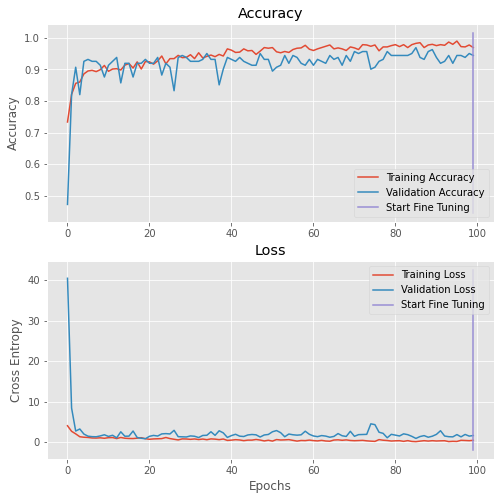

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/4 [======>.......................] - ETA: 0s - loss: 4.2132 - accuracy: 0.8828

2/4 [==============>...............] - ETA: 1s - loss: 3.1729 - accuracy: 0.9102

3/4 [=====================>........] - ETA: 1s - loss: 2.3395 - accuracy: 0.9297

4/4 [==============================] - ETA: 0s - loss: 2.0518 - accuracy: 0.9385

4/4 [==============================] - 13s 3s/step - loss: 2.0518 - accuracy: 0.9385


[2.051837921142578, 0.938524603843689]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

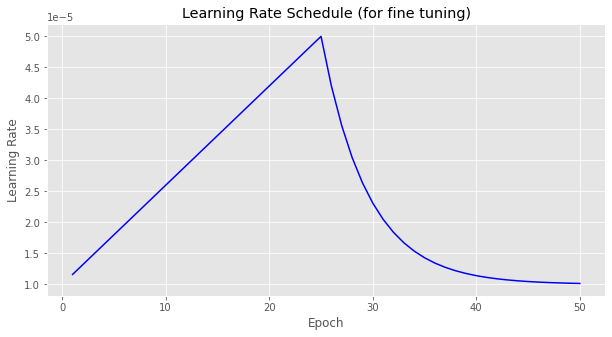

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 971 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 4s - loss: 0.1401 - accuracy: 0.9766    

 3/16 [====>.........................] - ETA: 7s - loss: 0.2525 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 9s - loss: 0.3234 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 8s - loss: 0.2665 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 9s - loss: 0.3213 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 8s - loss: 0.3248 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 8s - loss: 0.3063 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 7s - loss: 0.3280 - accuracy: 0.9757

10/16 [=================>............] - ETA: 6s - loss: 0.2952 - accuracy: 0.9781

11/16 [===================>..........] - ETA: 5s - loss: 0.2800 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 4s - loss: 0.3128 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2971 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 1s - loss: 0.2819 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 0s - loss: 0.2631 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.9794

16/16 [==============================] - 19s 1s/step - loss: 0.2601 - accuracy: 0.9794 - val_loss: 1.5816 - val_accuracy: 0.9441



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0837 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 6s - loss: 0.1519 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 15s - loss: 0.1267 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 11s - loss: 0.1421 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 13s - loss: 0.1137 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 13s - loss: 0.1536 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 12s - loss: 0.2806 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 11s - loss: 0.2791 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 10s - loss: 0.3410 - accuracy: 0.9722

10/16 [=================>............] - ETA: 8s - loss: 0.3421 - accuracy: 0.9719 

11/16 [===================>..........] - ETA: 6s - loss: 0.3173 - accuracy: 0.9730

12/16 [=====================>........] - ETA: 4s - loss: 0.3053 - accuracy: 0.9727

13/16 [=======================>......] - ETA: 3s - loss: 0.2819 - accuracy: 0.9748

14/16 [=========================>....] - ETA: 2s - loss: 0.2655 - accuracy: 0.9754

15/16 [===========================>..] - ETA: 1s - loss: 0.2682 - accuracy: 0.9750

16/16 [==============================] - ETA: 0s - loss: 0.2651 - accuracy: 0.9753

16/16 [==============================] - 19s 1s/step - loss: 0.2651 - accuracy: 0.9753 - val_loss: 1.5523 - val_accuracy: 0.9503



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 12s - loss: 0.0710 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 12s - loss: 0.0550 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 12s - loss: 0.0449 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 17s - loss: 0.0488 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 14s - loss: 0.0765 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 12s - loss: 0.0836 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 10s - loss: 0.0731 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 9s - loss: 0.0650 - accuracy: 0.9861 

10/16 [=================>............] - ETA: 8s - loss: 0.0585 - accuracy: 0.9875

11/16 [===================>..........] - ETA: 6s - loss: 0.0532 - accuracy: 0.9886

12/16 [=====================>........] - ETA: 4s - loss: 0.0488 - accuracy: 0.9896

13/16 [=======================>......] - ETA: 3s - loss: 0.0583 - accuracy: 0.9892

14/16 [=========================>....] - ETA: 2s - loss: 0.0574 - accuracy: 0.9888

15/16 [===========================>..] - ETA: 1s - loss: 0.0535 - accuracy: 0.9896

16/16 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9876

16/16 [==============================] - 19s 1s/step - loss: 0.1033 - accuracy: 0.9876 - val_loss: 1.5490 - val_accuracy: 0.9503



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0946 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 8s - loss: 0.0473 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 17s - loss: 0.1493 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 14s - loss: 0.1119 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 13s - loss: 0.2144 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 13s - loss: 0.1786 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 13s - loss: 0.1923 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 11s - loss: 0.1725 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.1544 - accuracy: 0.9826

10/16 [=================>............] - ETA: 8s - loss: 0.1713 - accuracy: 0.9828 

11/16 [===================>..........] - ETA: 6s - loss: 0.1928 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2062 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2219 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2064 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2220 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.9815

16/16 [==============================] - 20s 1s/step - loss: 0.2507 - accuracy: 0.9815 - val_loss: 1.5366 - val_accuracy: 0.9503



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3527 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 7s - loss: 0.3359 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 16s - loss: 0.2239 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 13s - loss: 0.1679 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 18s - loss: 0.1344 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 16s - loss: 0.1120 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 13s - loss: 0.1157 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 12s - loss: 0.1072 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 10s - loss: 0.0965 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.1022 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 6s - loss: 0.0932 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 5s - loss: 0.0854 - accuracy: 0.9883

13/16 [=======================>......] - ETA: 3s - loss: 0.0981 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.1084 - accuracy: 0.9866

15/16 [===========================>..] - ETA: 1s - loss: 0.1281 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9846

16/16 [==============================] - 20s 1s/step - loss: 0.1752 - accuracy: 0.9846 - val_loss: 1.5367 - val_accuracy: 0.9565



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1215 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 6s - loss: 0.2570 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 12s - loss: 0.1760 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 11s - loss: 0.1438 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 17s - loss: 0.2442 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 14s - loss: 0.2035 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 13s - loss: 0.2679 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.3967 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 10s - loss: 0.3847 - accuracy: 0.9809

10/16 [=================>............] - ETA: 8s - loss: 0.3796 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.3451 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.3214 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.4226 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.3927 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.3665 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.4370 - accuracy: 0.9815

16/16 [==============================] - 20s 1s/step - loss: 0.4370 - accuracy: 0.9815 - val_loss: 1.5322 - val_accuracy: 0.9565



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/16 [>.............................] - ETA: 0s - loss: 3.1665e-08 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 8s - loss: 0.2393 - accuracy: 0.9766    

 3/16 [====>.........................] - ETA: 9s - loss: 0.2068 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 10s - loss: 0.1551 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 13s - loss: 0.1526 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 12s - loss: 0.1337 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 10s - loss: 0.1249 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 9s - loss: 0.1589 - accuracy: 0.9805 

 9/16 [===============>..............] - ETA: 8s - loss: 0.1413 - accuracy: 0.9826

10/16 [=================>............] - ETA: 7s - loss: 0.1316 - accuracy: 0.9828

11/16 [===================>..........] - ETA: 6s - loss: 0.1235 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 4s - loss: 0.1211 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.1432 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.1469 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 1s - loss: 0.1371 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9825

16/16 [==============================] - 19s 1s/step - loss: 0.1355 - accuracy: 0.9825 - val_loss: 1.5026 - val_accuracy: 0.9565



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1136 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.1180 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 10s - loss: 0.1382 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 12s - loss: 0.2095 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 11s - loss: 0.1676 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 12s - loss: 0.1397 - accuracy: 0.9896

 7/16 [============>.................] - ETA: 12s - loss: 0.1656 - accuracy: 0.9888

 8/16 [==============>...............] - ETA: 11s - loss: 0.1858 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 10s - loss: 0.1846 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.2940 - accuracy: 0.9828 

11/16 [===================>..........] - ETA: 6s - loss: 0.2918 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.2675 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2469 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.2293 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.2140 - accuracy: 0.9865

16/16 [==============================] - ETA: 0s - loss: 0.2116 - accuracy: 0.9866

16/16 [==============================] - 20s 1s/step - loss: 0.2116 - accuracy: 0.9866 - val_loss: 1.4888 - val_accuracy: 0.9565



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2784 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.1392 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 16s - loss: 0.0928 - accuracy: 0.9948

 4/16 [======>.......................] - ETA: 15s - loss: 0.0730 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 12s - loss: 0.0926 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 13s - loss: 0.1335 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 12s - loss: 0.1146 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.1099 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 10s - loss: 0.1072 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.1213 - accuracy: 0.9828 

11/16 [===================>..........] - ETA: 6s - loss: 0.1220 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.1430 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.1441 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.1346 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.1280 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9815

16/16 [==============================] - 20s 1s/step - loss: 0.1461 - accuracy: 0.9815 - val_loss: 1.5021 - val_accuracy: 0.9565



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/16 [>.............................] - ETA: 0s - loss: 2.9709e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 1.4855e-04 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 7s - loss: 0.1339 - accuracy: 0.9948    

 4/16 [======>.......................] - ETA: 6s - loss: 0.1202 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 13s - loss: 0.0962 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 13s - loss: 0.2405 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 12s - loss: 0.2061 - accuracy: 0.9888

 8/16 [==============>...............] - ETA: 10s - loss: 0.2335 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 9s - loss: 0.2796 - accuracy: 0.9844 

10/16 [=================>............] - ETA: 7s - loss: 0.3129 - accuracy: 0.9828

11/16 [===================>..........] - ETA: 5s - loss: 0.3070 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 4s - loss: 0.2814 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.2641 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.2829 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2640 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2610 - accuracy: 0.9835

16/16 [==============================] - 18s 1s/step - loss: 0.2610 - accuracy: 0.9835 - val_loss: 1.4913 - val_accuracy: 0.9565



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/16 [>.............................] - ETA: 0s - loss: 1.9910e-06 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.0905 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 12s - loss: 0.0603 - accuracy: 0.9948

 4/16 [======>.......................] - ETA: 18s - loss: 0.0483 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 14s - loss: 0.0386 - accuracy: 0.9937

 6/16 [==========>...................] - ETA: 13s - loss: 0.0334 - accuracy: 0.9948

 7/16 [============>.................] - ETA: 11s - loss: 0.1076 - accuracy: 0.9888

 8/16 [==============>...............] - ETA: 9s - loss: 0.1273 - accuracy: 0.9863 

 9/16 [===============>..............] - ETA: 8s - loss: 0.1733 - accuracy: 0.9861

10/16 [=================>............] - ETA: 6s - loss: 0.1589 - accuracy: 0.9859

11/16 [===================>..........] - ETA: 5s - loss: 0.1523 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 4s - loss: 0.1396 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.1289 - accuracy: 0.9880

14/16 [=========================>....] - ETA: 2s - loss: 0.1268 - accuracy: 0.9866

15/16 [===========================>..] - ETA: 1s - loss: 0.1264 - accuracy: 0.9865

16/16 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9866

16/16 [==============================] - 19s 1s/step - loss: 0.1250 - accuracy: 0.9866 - val_loss: 1.4847 - val_accuracy: 0.9565



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2620 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 9s - loss: 0.1310 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 14s - loss: 0.2361 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 12s - loss: 0.5566 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 18s - loss: 0.4453 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 16s - loss: 0.4061 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 15s - loss: 0.3853 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 13s - loss: 0.4236 - accuracy: 0.9727

 9/16 [===============>..............] - ETA: 10s - loss: 0.3949 - accuracy: 0.9740

10/16 [=================>............] - ETA: 8s - loss: 0.3707 - accuracy: 0.9719 

11/16 [===================>..........] - ETA: 6s - loss: 0.4738 - accuracy: 0.9673

12/16 [=====================>........] - ETA: 5s - loss: 0.4362 - accuracy: 0.9688

13/16 [=======================>......] - ETA: 3s - loss: 0.4089 - accuracy: 0.9700

14/16 [=========================>....] - ETA: 2s - loss: 0.3866 - accuracy: 0.9710

15/16 [===========================>..] - ETA: 1s - loss: 0.3633 - accuracy: 0.9719

16/16 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.9712

16/16 [==============================] - 20s 1s/step - loss: 0.3769 - accuracy: 0.9712 - val_loss: 1.4739 - val_accuracy: 0.9565



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3464 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 6s - loss: 0.2065 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 16s - loss: 0.1377 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 14s - loss: 0.1789 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 14s - loss: 0.2405 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 11s - loss: 0.2004 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 12s - loss: 0.1943 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 11s - loss: 0.1701 - accuracy: 0.9883

 9/16 [===============>..............] - ETA: 10s - loss: 0.1751 - accuracy: 0.9878

10/16 [=================>............] - ETA: 8s - loss: 0.1579 - accuracy: 0.9891 

11/16 [===================>..........] - ETA: 6s - loss: 0.1435 - accuracy: 0.9901

12/16 [=====================>........] - ETA: 5s - loss: 0.1337 - accuracy: 0.9896

13/16 [=======================>......] - ETA: 3s - loss: 0.1843 - accuracy: 0.9880

14/16 [=========================>....] - ETA: 2s - loss: 0.1820 - accuracy: 0.9866

15/16 [===========================>..] - ETA: 1s - loss: 0.1699 - accuracy: 0.9875

16/16 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9866

16/16 [==============================] - 20s 1s/step - loss: 0.1814 - accuracy: 0.9866 - val_loss: 1.4731 - val_accuracy: 0.9503



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/16 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 2.7940e-08 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 12s - loss: 0.1390 - accuracy: 0.9844   

 4/16 [======>.......................] - ETA: 11s - loss: 0.3040 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 17s - loss: 0.2622 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 14s - loss: 0.2185 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 13s - loss: 0.2013 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 12s - loss: 0.3052 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.3124 - accuracy: 0.9809

10/16 [=================>............] - ETA: 8s - loss: 0.2815 - accuracy: 0.9828 

11/16 [===================>..........] - ETA: 6s - loss: 0.2718 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.3143 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.3556 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.3817 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.4005 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.9794

16/16 [==============================] - 20s 1s/step - loss: 0.3960 - accuracy: 0.9794 - val_loss: 1.4748 - val_accuracy: 0.9503



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/16 [>.............................] - ETA: 0s - loss: 1.6394e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 12s - loss: 0.1366 - accuracy: 0.9844   

 3/16 [====>.........................] - ETA: 12s - loss: 0.1827 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 12s - loss: 0.1397 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 14s - loss: 0.1686 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 13s - loss: 0.1638 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 11s - loss: 0.1421 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 9s - loss: 0.1245 - accuracy: 0.9863 

 9/16 [===============>..............] - ETA: 8s - loss: 0.1337 - accuracy: 0.9861

10/16 [=================>............] - ETA: 6s - loss: 0.1435 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 5s - loss: 0.1328 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 4s - loss: 0.1354 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.1807 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.1678 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.1703 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9846

16/16 [==============================] - 19s 1s/step - loss: 0.1684 - accuracy: 0.9846 - val_loss: 1.4802 - val_accuracy: 0.9503



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/16 [>.............................] - ETA: 0s - loss: 4.6357e-06 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 12s - loss: 0.0982 - accuracy: 0.9922   

 3/16 [====>.........................] - ETA: 12s - loss: 0.1548 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 11s - loss: 0.1582 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 12s - loss: 0.2006 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 11s - loss: 0.2685 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 12s - loss: 0.2301 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.2127 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 10s - loss: 0.2075 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.1952 - accuracy: 0.9828 

11/16 [===================>..........] - ETA: 6s - loss: 0.1944 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2089 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.1928 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.1898 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.1771 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9846

16/16 [==============================] - 20s 1s/step - loss: 0.1751 - accuracy: 0.9846 - val_loss: 1.4928 - val_accuracy: 0.9503



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1900 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 4s - loss: 0.0950 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 5s - loss: 0.1387 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 6s - loss: 0.1344 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 14s - loss: 0.1641 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 13s - loss: 0.1391 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 12s - loss: 0.1325 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.1314 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 9s - loss: 0.1244 - accuracy: 0.9844 

10/16 [=================>............] - ETA: 7s - loss: 0.1555 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 6s - loss: 0.1414 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 4s - loss: 0.1668 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.1612 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.1635 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.2209 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9835

16/16 [==============================] - 18s 1s/step - loss: 0.2184 - accuracy: 0.9835 - val_loss: 1.5131 - val_accuracy: 0.9503



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0384 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 6s - loss: 0.2647 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 16s - loss: 0.1783 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 14s - loss: 0.1589 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 13s - loss: 0.1273 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 13s - loss: 0.1061 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 12s - loss: 0.1198 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.1096 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 9s - loss: 0.0974 - accuracy: 0.9861 

10/16 [=================>............] - ETA: 8s - loss: 0.1130 - accuracy: 0.9859

11/16 [===================>..........] - ETA: 6s - loss: 0.1353 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 4s - loss: 0.1240 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.1555 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.1472 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.1373 - accuracy: 0.9865

16/16 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.9866

16/16 [==============================] - 19s 1s/step - loss: 0.1358 - accuracy: 0.9866 - val_loss: 1.5125 - val_accuracy: 0.9441



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1687 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 14s - loss: 0.1254 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 18s - loss: 0.1068 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 15s - loss: 0.0802 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 18s - loss: 0.0998 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 16s - loss: 0.1262 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 15s - loss: 0.1082 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 13s - loss: 0.0947 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 10s - loss: 0.1239 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.1126 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 6s - loss: 0.1030 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 5s - loss: 0.0946 - accuracy: 0.9883

13/16 [=======================>......] - ETA: 3s - loss: 0.0873 - accuracy: 0.9892

14/16 [=========================>....] - ETA: 2s - loss: 0.1168 - accuracy: 0.9888

15/16 [===========================>..] - ETA: 1s - loss: 0.1243 - accuracy: 0.9875

16/16 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.9866

16/16 [==============================] - 20s 1s/step - loss: 0.1314 - accuracy: 0.9866 - val_loss: 1.5200 - val_accuracy: 0.9441



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2317 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 13s - loss: 0.3404 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 10s - loss: 0.2270 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 13s - loss: 0.1702 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 13s - loss: 0.2821 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 13s - loss: 0.2352 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 10s - loss: 0.2324 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 9s - loss: 0.2035 - accuracy: 0.9863 

 9/16 [===============>..............] - ETA: 8s - loss: 0.2018 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.2431 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 6s - loss: 0.2230 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 4s - loss: 0.2163 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.2195 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2125 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2028 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9835

16/16 [==============================] - 19s 1s/step - loss: 0.2005 - accuracy: 0.9835 - val_loss: 1.5406 - val_accuracy: 0.9441



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/16 [>.............................] - ETA: 0s - loss: 1.0617e-07 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 12s - loss: 0.0278 - accuracy: 0.9922   

 3/16 [====>.........................] - ETA: 16s - loss: 0.0523 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 13s - loss: 0.0398 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 13s - loss: 0.2570 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 11s - loss: 0.2307 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 11s - loss: 0.2320 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 10s - loss: 0.2264 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 8s - loss: 0.2012 - accuracy: 0.9792 

10/16 [=================>............] - ETA: 7s - loss: 0.2052 - accuracy: 0.9797

11/16 [===================>..........] - ETA: 5s - loss: 0.2018 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 4s - loss: 0.1850 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.1745 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.1621 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.1599 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.9835

16/16 [==============================] - 19s 1s/step - loss: 0.1585 - accuracy: 0.9835 - val_loss: 1.5448 - val_accuracy: 0.9441



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/16 [>.............................] - ETA: 0s - loss: 0.6391 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 6s - loss: 0.3210 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 11s - loss: 0.2152 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 15s - loss: 0.1614 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 17s - loss: 0.1468 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 16s - loss: 0.1448 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 15s - loss: 0.2808 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 12s - loss: 0.3348 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.3199 - accuracy: 0.9792

10/16 [=================>............] - ETA: 8s - loss: 0.2880 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.2618 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2403 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.2744 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2765 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2765 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.9804

16/16 [==============================] - 20s 1s/step - loss: 0.2936 - accuracy: 0.9804 - val_loss: 1.5477 - val_accuracy: 0.9441



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 6s - loss: 0.0025 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 16s - loss: 0.0369 - accuracy: 0.9948

 4/16 [======>.......................] - ETA: 12s - loss: 0.0303 - accuracy: 0.9961

 5/16 [========>.....................] - ETA: 17s - loss: 0.0242 - accuracy: 0.9969

 6/16 [==========>...................] - ETA: 16s - loss: 0.0422 - accuracy: 0.9948

 7/16 [============>.................] - ETA: 14s - loss: 0.0362 - accuracy: 0.9955

 8/16 [==============>...............] - ETA: 13s - loss: 0.0709 - accuracy: 0.9922

 9/16 [===============>..............] - ETA: 10s - loss: 0.0870 - accuracy: 0.9913

10/16 [=================>............] - ETA: 8s - loss: 0.0783 - accuracy: 0.9922 

11/16 [===================>..........] - ETA: 6s - loss: 0.0923 - accuracy: 0.9886

12/16 [=====================>........] - ETA: 5s - loss: 0.0846 - accuracy: 0.9896

13/16 [=======================>......] - ETA: 3s - loss: 0.0991 - accuracy: 0.9892

14/16 [=========================>....] - ETA: 2s - loss: 0.1098 - accuracy: 0.9888

15/16 [===========================>..] - ETA: 1s - loss: 0.1025 - accuracy: 0.9896

16/16 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9897

16/16 [==============================] - 20s 1s/step - loss: 0.1013 - accuracy: 0.9897 - val_loss: 1.5536 - val_accuracy: 0.9503



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2957 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 12s - loss: 0.1872 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 12s - loss: 0.1248 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 13s - loss: 0.0955 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 13s - loss: 0.0767 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 13s - loss: 0.0639 - accuracy: 0.9922

 7/16 [============>.................] - ETA: 12s - loss: 0.0773 - accuracy: 0.9911

 8/16 [==============>...............] - ETA: 11s - loss: 0.0859 - accuracy: 0.9902

 9/16 [===============>..............] - ETA: 10s - loss: 0.0975 - accuracy: 0.9896

10/16 [=================>............] - ETA: 8s - loss: 0.1088 - accuracy: 0.9875 

11/16 [===================>..........] - ETA: 6s - loss: 0.0989 - accuracy: 0.9886

12/16 [=====================>........] - ETA: 5s - loss: 0.1043 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.0963 - accuracy: 0.9880

14/16 [=========================>....] - ETA: 2s - loss: 0.0934 - accuracy: 0.9877

15/16 [===========================>..] - ETA: 1s - loss: 0.1013 - accuracy: 0.9875

16/16 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9856

16/16 [==============================] - 20s 1s/step - loss: 0.1570 - accuracy: 0.9856 - val_loss: 1.5484 - val_accuracy: 0.9503



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.4230 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 14s - loss: 0.2820 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 11s - loss: 0.2127 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 13s - loss: 0.1824 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 12s - loss: 0.1520 - accuracy: 0.9896

 7/16 [============>.................] - ETA: 12s - loss: 0.1303 - accuracy: 0.9911

 8/16 [==============>...............] - ETA: 11s - loss: 0.1538 - accuracy: 0.9902

 9/16 [===============>..............] - ETA: 10s - loss: 0.1367 - accuracy: 0.9913

10/16 [=================>............] - ETA: 8s - loss: 0.1470 - accuracy: 0.9875 

11/16 [===================>..........] - ETA: 6s - loss: 0.1337 - accuracy: 0.9886

12/16 [=====================>........] - ETA: 4s - loss: 0.1225 - accuracy: 0.9896

13/16 [=======================>......] - ETA: 3s - loss: 0.1306 - accuracy: 0.9892

14/16 [=========================>....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9900

15/16 [===========================>..] - ETA: 1s - loss: 0.1207 - accuracy: 0.9896

16/16 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9887

16/16 [==============================] - 19s 1s/step - loss: 0.1268 - accuracy: 0.9887 - val_loss: 1.5521 - val_accuracy: 0.9503



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7134 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 3s - loss: 0.4105 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 7s - loss: 0.5534 - accuracy: 0.9583

 4/16 [======>.......................] - ETA: 10s - loss: 0.4154 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 13s - loss: 0.3323 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 15s - loss: 0.2890 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 12s - loss: 0.2477 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 10s - loss: 0.2492 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 8s - loss: 0.2368 - accuracy: 0.9792 

10/16 [=================>............] - ETA: 7s - loss: 0.2703 - accuracy: 0.9781

11/16 [===================>..........] - ETA: 6s - loss: 0.2458 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 4s - loss: 0.2573 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.2643 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2945 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.2801 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.2772 - accuracy: 0.9784

16/16 [==============================] - 18s 1s/step - loss: 0.2772 - accuracy: 0.9784 - val_loss: 1.5307 - val_accuracy: 0.9441



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/16 [>.............................] - ETA: 0s - loss: 0.6706 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 14s - loss: 0.3989 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 14s - loss: 0.2717 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 14s - loss: 0.2038 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 18s - loss: 0.1630 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 16s - loss: 0.1358 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 15s - loss: 0.1580 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 12s - loss: 0.1383 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 10s - loss: 0.1250 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.1160 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 6s - loss: 0.1054 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 5s - loss: 0.1015 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.1157 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.1299 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.1245 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9846

16/16 [==============================] - 20s 1s/step - loss: 0.1231 - accuracy: 0.9846 - val_loss: 1.5346 - val_accuracy: 0.9441



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0930 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.0952 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 10s - loss: 0.1514 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 8s - loss: 0.1690 - accuracy: 0.9766 

 5/16 [========>.....................] - ETA: 13s - loss: 0.2895 - accuracy: 0.9688

 6/16 [==========>...................] - ETA: 12s - loss: 0.2680 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 12s - loss: 0.2297 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 11s - loss: 0.2084 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 9s - loss: 0.2781 - accuracy: 0.9740 

10/16 [=================>............] - ETA: 8s - loss: 0.2740 - accuracy: 0.9750

11/16 [===================>..........] - ETA: 6s - loss: 0.2490 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 4s - loss: 0.2834 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.2616 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2431 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.2663 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.2633 - accuracy: 0.9804

16/16 [==============================] - 19s 1s/step - loss: 0.2633 - accuracy: 0.9804 - val_loss: 1.5394 - val_accuracy: 0.9503



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/16 [>.............................] - ETA: 0s - loss: 0.6830 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 6s - loss: 0.3731 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 16s - loss: 0.2617 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 13s - loss: 0.3002 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 14s - loss: 0.2803 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 14s - loss: 0.3192 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 13s - loss: 0.3064 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 12s - loss: 0.2681 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.2536 - accuracy: 0.9809

10/16 [=================>............] - ETA: 8s - loss: 0.2386 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.2169 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2740 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.2812 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2638 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2462 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.9835

16/16 [==============================] - 20s 1s/step - loss: 0.2434 - accuracy: 0.9835 - val_loss: 1.5397 - val_accuracy: 0.9503



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/16 [>.............................] - ETA: 0s - loss: 4.4095e-05 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.2343 - accuracy: 0.9844    

 3/16 [====>.........................] - ETA: 16s - loss: 0.1562 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 18s - loss: 0.1930 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 14s - loss: 0.3162 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 13s - loss: 0.4141 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 10s - loss: 0.3713 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 9s - loss: 0.3270 - accuracy: 0.9844 

 9/16 [===============>..............] - ETA: 9s - loss: 0.3553 - accuracy: 0.9826

10/16 [=================>............] - ETA: 7s - loss: 0.3342 - accuracy: 0.9812

11/16 [===================>..........] - ETA: 6s - loss: 0.3038 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 4s - loss: 0.2812 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2596 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.2944 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.3362 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.9815

16/16 [==============================] - 19s 1s/step - loss: 0.3324 - accuracy: 0.9815 - val_loss: 1.5407 - val_accuracy: 0.9441



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/16 [>.............................] - ETA: 0s - loss: 2.6077e-07 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.0215 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 12s - loss: 0.0250 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 10s - loss: 0.1575 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 11s - loss: 0.1260 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 11s - loss: 0.2352 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 9s - loss: 0.2016 - accuracy: 0.9866 

 8/16 [==============>...............] - ETA: 8s - loss: 0.2515 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 8s - loss: 0.2332 - accuracy: 0.9826

10/16 [=================>............] - ETA: 7s - loss: 0.2099 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 5s - loss: 0.1987 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 4s - loss: 0.2237 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2329 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2162 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2019 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9846

16/16 [==============================] - 18s 1s/step - loss: 0.1996 - accuracy: 0.9846 - val_loss: 1.5481 - val_accuracy: 0.9441



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0468 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.1566 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 12s - loss: 0.1597 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 12s - loss: 0.1406 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 12s - loss: 0.2116 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 12s - loss: 0.2400 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 12s - loss: 0.4339 - accuracy: 0.9665

 8/16 [==============>...............] - ETA: 11s - loss: 0.4009 - accuracy: 0.9668

 9/16 [===============>..............] - ETA: 10s - loss: 0.3598 - accuracy: 0.9688

10/16 [=================>............] - ETA: 8s - loss: 0.3271 - accuracy: 0.9703 

11/16 [===================>..........] - ETA: 6s - loss: 0.3140 - accuracy: 0.9702

12/16 [=====================>........] - ETA: 4s - loss: 0.3321 - accuracy: 0.9688

13/16 [=======================>......] - ETA: 3s - loss: 0.3440 - accuracy: 0.9688

14/16 [=========================>....] - ETA: 2s - loss: 0.3198 - accuracy: 0.9710

15/16 [===========================>..] - ETA: 1s - loss: 0.3131 - accuracy: 0.9708

16/16 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.9701

16/16 [==============================] - 19s 1s/step - loss: 0.3180 - accuracy: 0.9701 - val_loss: 1.5529 - val_accuracy: 0.9441



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/16 [>.............................] - ETA: 0s - loss: 7.1360e-06 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.0250 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 12s - loss: 0.3888 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 14s - loss: 0.3386 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 17s - loss: 0.3616 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 16s - loss: 0.3649 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 15s - loss: 0.3128 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 12s - loss: 0.3058 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 10s - loss: 0.2927 - accuracy: 0.9757

10/16 [=================>............] - ETA: 8s - loss: 0.3267 - accuracy: 0.9734 

11/16 [===================>..........] - ETA: 6s - loss: 0.2973 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.2727 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2539 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2479 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.2314 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9794

16/16 [==============================] - 20s 1s/step - loss: 0.2288 - accuracy: 0.9794 - val_loss: 1.5521 - val_accuracy: 0.9441



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5275 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 15s - loss: 0.2684 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 14s - loss: 0.2259 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 11s - loss: 0.2292 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 12s - loss: 0.1834 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 13s - loss: 0.1657 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 12s - loss: 0.1744 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.2234 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.3002 - accuracy: 0.9792

10/16 [=================>............] - ETA: 8s - loss: 0.2701 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.2953 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.2986 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.2773 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2575 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 1s - loss: 0.2661 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.9815

16/16 [==============================] - 20s 1s/step - loss: 0.2631 - accuracy: 0.9815 - val_loss: 1.5521 - val_accuracy: 0.9441



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/16 [>.............................] - ETA: 0s - loss: 2.7753e-07 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 9s - loss: 0.3120 - accuracy: 0.9844    

 3/16 [====>.........................] - ETA: 10s - loss: 0.3002 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 15s - loss: 0.2721 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 12s - loss: 0.2914 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 12s - loss: 0.3080 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 11s - loss: 0.2985 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 9s - loss: 0.3234 - accuracy: 0.9766 

 9/16 [===============>..............] - ETA: 8s - loss: 0.3038 - accuracy: 0.9774

10/16 [=================>............] - ETA: 7s - loss: 0.2734 - accuracy: 0.9797

11/16 [===================>..........] - ETA: 6s - loss: 0.2486 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 4s - loss: 0.2279 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2440 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2403 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2289 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.9804

16/16 [==============================] - 19s 1s/step - loss: 0.2270 - accuracy: 0.9804 - val_loss: 1.5482 - val_accuracy: 0.9503



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5080 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 8s - loss: 0.4505 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 14s - loss: 0.3004 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 11s - loss: 0.2828 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 17s - loss: 0.2494 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 16s - loss: 0.2493 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 12s - loss: 0.3439 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 11s - loss: 0.3009 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 10s - loss: 0.2702 - accuracy: 0.9792

10/16 [=================>............] - ETA: 8s - loss: 0.3062 - accuracy: 0.9766 

11/16 [===================>..........] - ETA: 6s - loss: 0.3296 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.3351 - accuracy: 0.9753

13/16 [=======================>......] - ETA: 3s - loss: 0.3216 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.2993 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.3209 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 0.9784

16/16 [==============================] - 20s 1s/step - loss: 0.3173 - accuracy: 0.9784 - val_loss: 1.5424 - val_accuracy: 0.9503



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/16 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.0240 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 7s - loss: 0.2304 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 9s - loss: 0.2216 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 15s - loss: 0.1773 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 15s - loss: 0.1478 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 14s - loss: 0.1267 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 11s - loss: 0.1108 - accuracy: 0.9883

 9/16 [===============>..............] - ETA: 10s - loss: 0.1226 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.1103 - accuracy: 0.9875 

11/16 [===================>..........] - ETA: 6s - loss: 0.1041 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 4s - loss: 0.0963 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.1275 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.1764 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2196 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9804

16/16 [==============================] - 19s 1s/step - loss: 0.2171 - accuracy: 0.9804 - val_loss: 1.5406 - val_accuracy: 0.9503



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/16 [>.............................] - ETA: 0s - loss: 1.0412e-06 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 8s - loss: 0.1191 - accuracy: 0.9844    

 3/16 [====>.........................] - ETA: 10s - loss: 0.0794 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 10s - loss: 0.0596 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 13s - loss: 0.0911 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 12s - loss: 0.0759 - accuracy: 0.9922

 7/16 [============>.................] - ETA: 10s - loss: 0.0801 - accuracy: 0.9911

 8/16 [==============>...............] - ETA: 9s - loss: 0.0701 - accuracy: 0.9922 

 9/16 [===============>..............] - ETA: 7s - loss: 0.0624 - accuracy: 0.9931

10/16 [=================>............] - ETA: 6s - loss: 0.0652 - accuracy: 0.9922

11/16 [===================>..........] - ETA: 5s - loss: 0.0593 - accuracy: 0.9929

12/16 [=====================>........] - ETA: 4s - loss: 0.0543 - accuracy: 0.9935

13/16 [=======================>......] - ETA: 3s - loss: 0.0712 - accuracy: 0.9928

14/16 [=========================>....] - ETA: 2s - loss: 0.0762 - accuracy: 0.9922

15/16 [===========================>..] - ETA: 1s - loss: 0.0712 - accuracy: 0.9927

16/16 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9928

16/16 [==============================] - 19s 1s/step - loss: 0.0704 - accuracy: 0.9928 - val_loss: 1.5422 - val_accuracy: 0.9503



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 8s - loss: 0.0081 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 9s - loss: 0.1195 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 10s - loss: 0.0896 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 13s - loss: 0.0717 - accuracy: 0.9937

 6/16 [==========>...................] - ETA: 12s - loss: 0.1668 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 10s - loss: 0.1686 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 9s - loss: 0.2715 - accuracy: 0.9844 

 9/16 [===============>..............] - ETA: 8s - loss: 0.2855 - accuracy: 0.9826

10/16 [=================>............] - ETA: 7s - loss: 0.3199 - accuracy: 0.9828

11/16 [===================>..........] - ETA: 6s - loss: 0.4090 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 4s - loss: 0.3749 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.3887 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.3707 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.3473 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.3434 - accuracy: 0.9804

16/16 [==============================] - 19s 1s/step - loss: 0.3434 - accuracy: 0.9804 - val_loss: 1.5513 - val_accuracy: 0.9503



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.1083 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 19s - loss: 0.1632 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 15s - loss: 0.1224 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 17s - loss: 0.1301 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 16s - loss: 0.1085 - accuracy: 0.9922

 7/16 [============>.................] - ETA: 14s - loss: 0.0930 - accuracy: 0.9933

 8/16 [==============>...............] - ETA: 13s - loss: 0.0814 - accuracy: 0.9941

 9/16 [===============>..............] - ETA: 10s - loss: 0.1014 - accuracy: 0.9913

10/16 [=================>............] - ETA: 8s - loss: 0.1138 - accuracy: 0.9906 

11/16 [===================>..........] - ETA: 6s - loss: 0.1042 - accuracy: 0.9915

12/16 [=====================>........] - ETA: 5s - loss: 0.1358 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.1496 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.1695 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.2123 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.9825

16/16 [==============================] - 20s 1s/step - loss: 0.2257 - accuracy: 0.9825 - val_loss: 1.5498 - val_accuracy: 0.9503



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/16 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 19s - loss: 6.3330e-08 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 13s - loss: 0.0085 - accuracy: 0.9948    

 4/16 [======>.......................] - ETA: 16s - loss: 0.0063 - accuracy: 0.9961

 5/16 [========>.....................] - ETA: 16s - loss: 0.0745 - accuracy: 0.9937

 6/16 [==========>...................] - ETA: 15s - loss: 0.0621 - accuracy: 0.9948

 7/16 [============>.................] - ETA: 14s - loss: 0.0539 - accuracy: 0.9955

 8/16 [==============>...............] - ETA: 12s - loss: 0.0722 - accuracy: 0.9941

 9/16 [===============>..............] - ETA: 10s - loss: 0.0643 - accuracy: 0.9948

10/16 [=================>............] - ETA: 8s - loss: 0.0602 - accuracy: 0.9937 

11/16 [===================>..........] - ETA: 6s - loss: 0.0547 - accuracy: 0.9943

12/16 [=====================>........] - ETA: 4s - loss: 0.0502 - accuracy: 0.9948

13/16 [=======================>......] - ETA: 3s - loss: 0.0670 - accuracy: 0.9928

14/16 [=========================>....] - ETA: 2s - loss: 0.1203 - accuracy: 0.9900

15/16 [===========================>..] - ETA: 1s - loss: 0.1168 - accuracy: 0.9896

16/16 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.9897

16/16 [==============================] - 19s 1s/step - loss: 0.1155 - accuracy: 0.9897 - val_loss: 1.5620 - val_accuracy: 0.9503



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3991 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 9s - loss: 0.3428 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 18s - loss: 0.2286 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 13s - loss: 0.2058 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 17s - loss: 0.1649 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 17s - loss: 0.2263 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 15s - loss: 0.1950 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 12s - loss: 0.2277 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 10s - loss: 0.2063 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.2081 - accuracy: 0.9844 

11/16 [===================>..........] - ETA: 6s - loss: 0.1892 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.1742 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.1608 - accuracy: 0.9880

14/16 [=========================>....] - ETA: 2s - loss: 0.1588 - accuracy: 0.9877

15/16 [===========================>..] - ETA: 1s - loss: 0.1700 - accuracy: 0.9875

16/16 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.9876

16/16 [==============================] - 20s 1s/step - loss: 0.1680 - accuracy: 0.9876 - val_loss: 1.5772 - val_accuracy: 0.9503



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/16 [>.............................] - ETA: 0s - loss: 3.1480e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 1.5788e-04 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 19s - loss: 0.0874 - accuracy: 0.9948   

 4/16 [======>.......................] - ETA: 17s - loss: 0.0679 - accuracy: 0.9961

 5/16 [========>.....................] - ETA: 14s - loss: 0.1169 - accuracy: 0.9937

 6/16 [==========>...................] - ETA: 14s - loss: 0.1298 - accuracy: 0.9922

 7/16 [============>.................] - ETA: 11s - loss: 0.1384 - accuracy: 0.9888

 8/16 [==============>...............] - ETA: 10s - loss: 0.1231 - accuracy: 0.9883

 9/16 [===============>..............] - ETA: 8s - loss: 0.1173 - accuracy: 0.9878 

10/16 [=================>............] - ETA: 7s - loss: 0.1055 - accuracy: 0.9891

11/16 [===================>..........] - ETA: 5s - loss: 0.1221 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 4s - loss: 0.2128 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.2111 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.2039 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.2163 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9835

16/16 [==============================] - 19s 1s/step - loss: 0.2262 - accuracy: 0.9835 - val_loss: 1.5634 - val_accuracy: 0.9503



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/16 [>.............................] - ETA: 0s - loss: 0.4817 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 6s - loss: 0.2819 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 12s - loss: 0.2613 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 11s - loss: 0.1986 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 17s - loss: 0.2182 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 16s - loss: 0.1836 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 13s - loss: 0.1574 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 12s - loss: 0.1465 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 10s - loss: 0.1525 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.2023 - accuracy: 0.9844 

11/16 [===================>..........] - ETA: 6s - loss: 0.1839 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.1722 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.1589 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.1713 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.1600 - accuracy: 0.9865

16/16 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9866

16/16 [==============================] - 20s 1s/step - loss: 0.1582 - accuracy: 0.9866 - val_loss: 1.5641 - val_accuracy: 0.9503



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/16 [>.............................] - ETA: 0s - loss: 1.2200e-06 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.1630 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 14s - loss: 0.3090 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 12s - loss: 0.2318 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 12s - loss: 0.2522 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 13s - loss: 0.2255 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 12s - loss: 0.1933 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 11s - loss: 0.1893 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 10s - loss: 0.1683 - accuracy: 0.9878

10/16 [=================>............] - ETA: 8s - loss: 0.2114 - accuracy: 0.9875 

11/16 [===================>..........] - ETA: 6s - loss: 0.2137 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.2431 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.2245 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.2310 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.2156 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.9856

16/16 [==============================] - 20s 1s/step - loss: 0.2132 - accuracy: 0.9856 - val_loss: 1.5733 - val_accuracy: 0.9503



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 11s - loss: 0.0011 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 11s - loss: 0.0023 - accuracy: 1.0000

 4/16 [======>.......................] - ETA: 11s - loss: 0.0641 - accuracy: 0.9961

 5/16 [========>.....................] - ETA: 12s - loss: 0.0513 - accuracy: 0.9969

 6/16 [==========>...................] - ETA: 13s - loss: 0.0436 - accuracy: 0.9974

 7/16 [============>.................] - ETA: 12s - loss: 0.0575 - accuracy: 0.9933

 8/16 [==============>...............] - ETA: 11s - loss: 0.1565 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 10s - loss: 0.1391 - accuracy: 0.9878

10/16 [=================>............] - ETA: 8s - loss: 0.1252 - accuracy: 0.9891 

11/16 [===================>..........] - ETA: 6s - loss: 0.1264 - accuracy: 0.9886

12/16 [=====================>........] - ETA: 5s - loss: 0.1159 - accuracy: 0.9896

13/16 [=======================>......] - ETA: 3s - loss: 0.1193 - accuracy: 0.9880

14/16 [=========================>....] - ETA: 2s - loss: 0.1108 - accuracy: 0.9888

15/16 [===========================>..] - ETA: 1s - loss: 0.1194 - accuracy: 0.9885

16/16 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9876

16/16 [==============================] - 20s 1s/step - loss: 0.1376 - accuracy: 0.9876 - val_loss: 1.5788 - val_accuracy: 0.9503



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 9.7317e-05 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 12s - loss: 0.1458 - accuracy: 0.9896   

 4/16 [======>.......................] - ETA: 10s - loss: 0.2103 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 16s - loss: 0.1682 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 15s - loss: 0.1610 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 14s - loss: 0.1441 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 12s - loss: 0.1272 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 10s - loss: 0.1130 - accuracy: 0.9878

10/16 [=================>............] - ETA: 8s - loss: 0.1017 - accuracy: 0.9891 

11/16 [===================>..........] - ETA: 6s - loss: 0.1213 - accuracy: 0.9886

12/16 [=====================>........] - ETA: 4s - loss: 0.1112 - accuracy: 0.9896

13/16 [=======================>......] - ETA: 3s - loss: 0.1440 - accuracy: 0.9892

14/16 [=========================>....] - ETA: 2s - loss: 0.1611 - accuracy: 0.9888

15/16 [===========================>..] - ETA: 1s - loss: 0.1793 - accuracy: 0.9885

16/16 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9887

16/16 [==============================] - 19s 1s/step - loss: 0.1773 - accuracy: 0.9887 - val_loss: 1.5670 - val_accuracy: 0.9503



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0374 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 11s - loss: 0.0187 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 9s - loss: 0.0453 - accuracy: 0.9896 

 4/16 [======>.......................] - ETA: 7s - loss: 0.0854 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 9s - loss: 0.0691 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 10s - loss: 0.0576 - accuracy: 0.9922

 7/16 [============>.................] - ETA: 10s - loss: 0.0494 - accuracy: 0.9933

 8/16 [==============>...............] - ETA: 9s - loss: 0.1491 - accuracy: 0.9902 

 9/16 [===============>..............] - ETA: 9s - loss: 0.1879 - accuracy: 0.9896

10/16 [=================>............] - ETA: 7s - loss: 0.1711 - accuracy: 0.9891

11/16 [===================>..........] - ETA: 5s - loss: 0.1555 - accuracy: 0.9901

12/16 [=====================>........] - ETA: 4s - loss: 0.1426 - accuracy: 0.9909

13/16 [=======================>......] - ETA: 3s - loss: 0.1316 - accuracy: 0.9916

14/16 [=========================>....] - ETA: 2s - loss: 0.1223 - accuracy: 0.9922

15/16 [===========================>..] - ETA: 0s - loss: 0.1414 - accuracy: 0.9917

16/16 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9907

16/16 [==============================] - 18s 1s/step - loss: 0.1754 - accuracy: 0.9907 - val_loss: 1.5556 - val_accuracy: 0.9503



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/16 [>.............................] - ETA: 0s - loss: 1.4612 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 15s - loss: 0.7313 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 18s - loss: 0.5580 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 17s - loss: 0.6167 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 15s - loss: 0.5095 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 14s - loss: 0.5539 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 11s - loss: 0.4748 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 10s - loss: 0.4157 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 8s - loss: 0.4376 - accuracy: 0.9809 

10/16 [=================>............] - ETA: 7s - loss: 0.3939 - accuracy: 0.9828

11/16 [===================>..........] - ETA: 5s - loss: 0.3581 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 4s - loss: 0.3412 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.3150 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.2998 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.2975 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.2941 - accuracy: 0.9856

16/16 [==============================] - 19s 1s/step - loss: 0.2941 - accuracy: 0.9856 - val_loss: 1.5575 - val_accuracy: 0.9503



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2976 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 14s - loss: 0.2144 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 14s - loss: 0.2023 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 14s - loss: 0.1739 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 13s - loss: 0.1391 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 11s - loss: 0.1537 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 10s - loss: 0.1317 - accuracy: 0.9888

 8/16 [==============>...............] - ETA: 8s - loss: 0.1155 - accuracy: 0.9902 

 9/16 [===============>..............] - ETA: 7s - loss: 0.1651 - accuracy: 0.9896

10/16 [=================>............] - ETA: 6s - loss: 0.1486 - accuracy: 0.9906

11/16 [===================>..........] - ETA: 5s - loss: 0.1852 - accuracy: 0.9886

12/16 [=====================>........] - ETA: 4s - loss: 0.1942 - accuracy: 0.9883

13/16 [=======================>......] - ETA: 3s - loss: 0.2487 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 1s - loss: 0.2432 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 0s - loss: 0.2752 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.9804

16/16 [==============================] - 17s 1s/step - loss: 0.2721 - accuracy: 0.9804 - val_loss: 1.5509 - val_accuracy: 0.9441


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

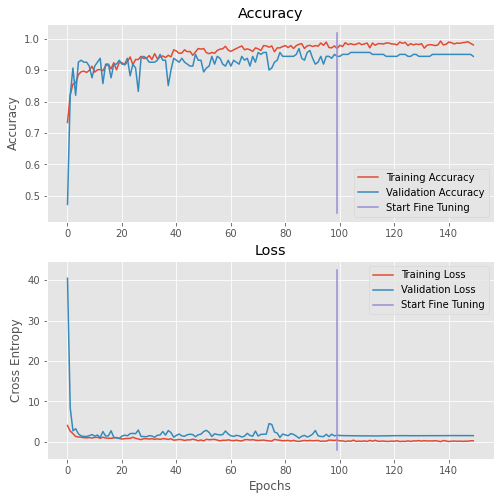

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/4 [======>.......................] - ETA: 0s - loss: 3.2203 - accuracy: 0.8906

2/4 [==============>...............] - ETA: 1s - loss: 2.5170 - accuracy: 0.9180

3/4 [=====================>........] - ETA: 1s - loss: 1.9319 - accuracy: 0.9323

4/4 [==============================] - ETA: 0s - loss: 1.7893 - accuracy: 0.9385

4/4 [==============================] - 5s 1s/step - loss: 1.7893 - accuracy: 0.9385


[1.7893186807632446, 0.938524603843689]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9385245901639344
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       148
           1       0.95      0.96      0.96       340

    accuracy                           0.94       488
   macro avg       0.93      0.92      0.93       488
weighted avg       0.94      0.94      0.94       488



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

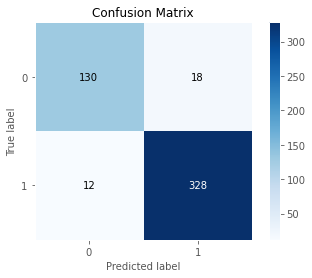

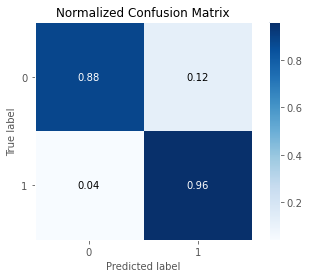

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

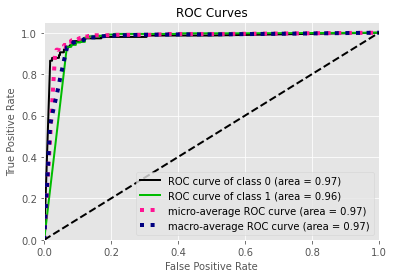

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       148
           1       0.95      0.96      0.96       340

    accuracy                           0.94       488
   macro avg       0.93      0.92      0.93       488
weighted avg       0.94      0.94      0.94       488

                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.88      0.96      0.90      0.92      0.84       148
          1       0.95      0.96      0.88      0.96      0.92      0.85       340

avg / total       0.94      0.94      0.90      0.94      0.92      0.85       488

